**Eric Meinhardt / emeinhardt@ucsd.edu**

In [1]:
#Prints **all** console output, not just last item in cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

In [3]:
from functools import reduce

In [4]:
from itertools import chain

In [5]:
import re
from more_itertools import replace
from funcy import compose

In [6]:
from joblib import Parallel, delayed

J = 10
BACKEND = 'multiprocessing'
# BACKEND = 'loky'
V = 10
PREFER = 'processes'
# PREFER = 'threads'

def par(gen_expr):
    return Parallel(n_jobs=J, backend=BACKEND, verbose=V, prefer=PREFER)(gen_expr)

In [7]:
import json

In [8]:
import pandas as pd
from plotnine import *

# Overview

This notebook documents code for pre-processing the Fisher corpus transcripts into an easier-to-work-with (=relational) format, and into a format that facilitates creating an n-gram model using `kenlm` (= one utterance per line with non-speech events and disfluencies removed or altered to taste).

## Dependencies
 - Fisher corpus transcripts.
 - **`more_itertools`**
 - **`funcy`**
 - **`joblib`**
 - **`Unix`-like OS:** The notebook uses `*nix` shell command magics (mostly `cat` and `head`) as a lightweight means of peeking at files.
 - **`pandas`+`plotnine`:** The notebook uses `pandas` and `plotnine` to plot pre-segmented utterance lengths and the distribution over times between consecutive utterance-onsets.
 - **`kenlm`:** At the end of the notebook, I use shell command magics to call `kenlm`; I also import the `kenlm` python package.
 
The last three items aren't essential for processing/interfacing with the Fisher corpus. `funcy`, `more_itertools`, and `joblib` happen to be used, but could certainly be replaced without too much trouble.

## Outputs

For both the 'main' transcriptions done by the LDC and the BBN ones, this notebook produces
 1. a single .json file containing all of the information contained in the original data formats, plus a processed version of each utterance.
 2. a single .txt file containing vocabulary from the (processed) utterances.
 3. a single .txt file containing one (processed) utterance per line - suitable for input to kenlm.
 
The code at the end will use kenlm to produce .arpa and .mmap files

## Utterance processing

### Double parentheses
The main (LDC) transcriptions features double parentheses around wordform (sequences) the transcriber wasn't sure of, with text in the double parentheses indicating the transcriber's best guess (if any). Here are some examples (each taken from different conversations):
```
512.82 515.29 A: i so much wanted to be (( ))
```
```
67.12 68.65 A: yeah the last (( )) yeah
```
```
81.27 83.44 B: were you close to where the (( )) tornados
```
```
2.53 4.06 B: (( [noise] hello how are you doing my ))
```
```
91.72 96.48 B: oh bio terror terrorism is a little (( out of prevented )) i don't know (( -bout ))
```
I've removed all double parentheses and kept whatever's inside the parentheses (if anything). If nothing appears, it's been replaced with a custom "unknown" token `<rem>`. (The `kenlm` "unknown" token `<unk>` cannot appear in the data you hand it.)

### Non-speech noises

Anything appearing in square brackets (e.g. `[noise]` above) has been removed in the processed version of each utterance.

### Broken off and resumed words

Wordforms that are broken off in the middle or that are resumed end (or start) in the transcriptions with a dash:
```
281.04 283.89 A: i f- i know i found my job on line i it was
```
```
175.78 178.65 B: uh huh it's r- i love it
```
```
I THINK HUMAN BEINGS ARE PR- UM [LIPSMACK] FRIENDSHIP RELAT- RELATIONSHIPS WITH PEOPLE ARE A LOT MORE IMPORTANT THAN MONEY  (fe_03_05863-A-0012)
```
```
91.72 96.48 B: oh bio terror terrorism is a little (( out of prevented )) i don't know (( -bout ))
```
```
okay yeah s- we- -ll disney is pretty safe and pretty good
```
```
they have the pales- -tin- -instinians and all that stuff going on
```

While occasionally a word is started, interrupted, and then resumed (as in the last example) in a way that indicates what the speaker intended, there are very few of these - few enough of these that it's not worth 'fixing' them.

Any wordform starting or ending with a dash has been replaced with `<rem>`.

### Case

All wordforms have been converted to lowercase.

### Altogether

In [9]:
# unk = '<unk>'
unk = '<rem>'

In [10]:
def remove_double_parens(speech, insertUnk=True):
    if insertUnk:
        speech = speech.replace("(( ))", unk)
    speech_wordform_seq = speech.split(' ')
    filtered = [w for w in speech_wordform_seq if w != '((' and w != '))']
    return ' '.join(filtered)

remove_double_parens('(( no way )) money can be substituted for her no way')
remove_double_parens("(( )) on friday and i have to work it's my last day with them i teach preschool so")
remove_double_parens("were you close to where the (( )) tornados")
remove_double_parens("were you close to where the (( )) tornados", False)

'no way money can be substituted for her no way'

"<rem> on friday and i have to work it's my last day with them i teach preschool so"

'were you close to where the <rem> tornados'

'were you close to where the tornados'

In [11]:
def remove_non_speech(speech):
    speech_filtered_words = [w for w in speech.split(' ') if len(w) > 0 and w[0] != '[' and w[-1] != ']']
    speech_out = ' '.join(speech_filtered_words)
    speech_out = speech_out.rstrip()
    return speech_out

remove_non_speech("I THINK HUMAN BEINGS ARE PR- UM [LIPSMACK] FRIENDSHIP RELAT- RELATIONSHIPS WITH PEOPLE ARE A LOT MORE IMPORTANT THAN MONEY")
remove_non_speech(remove_double_parens("(( [noise] hello how are you doing my ))"))

'I THINK HUMAN BEINGS ARE PR- UM FRIENDSHIP RELAT- RELATIONSHIPS WITH PEOPLE ARE A LOT MORE IMPORTANT THAN MONEY'

'hello how are you doing my'

In [12]:
interrupted_word_pattern = ".*-$"
resumed_word_pattern = "^-.*"

def isInterrupted(wordform):
    return re.match(interrupted_word_pattern, wordform) is not None

def isResumed(wordform):
    return re.match(resumed_word_pattern, wordform) is not None

def isBroken(wordform):
    return isInterrupted(wordform) or isResumed(wordform)

def hasBrokenWords(speech):
    speech_word_seq = speech.split(' ')
    broken_words = list(filter(isBroken, speech_word_seq))
    return len(broken_words) > 0

def remove_broken_words(speech, insertUnk=True):
    if insertUnk:
        replacement = unk
    else:
        replacement = ""
        
    speech_word_seq = speech.split(' ')
    speech_word_seq_fixed = ' '.join(replace(speech_word_seq, isBroken, (replacement,)))
    speech_fixed = ' '.join([w for w in speech_word_seq_fixed.split(' ') if len(w) > 0])
    return speech_fixed

remove_broken_words("uh huh it's r- i love it")
remove_broken_words('okay yeah s- we- -ll disney is pretty safe and pretty good')
remove_broken_words('they have the pales- -tin- -instinians and all that stuff going on')

"uh huh it's <rem> i love it"

'okay yeah <rem> <rem> <rem> disney is pretty safe and pretty good'

'they have the <rem> <rem> <rem> and all that stuff going on'

In [13]:
def lowercase(speech):
    return speech.lower()

In [14]:
process = compose(lowercase, remove_broken_words, remove_non_speech, remove_double_parens)

In [15]:
process('(( no way )) money can be substituted for her no way')
process("I THINK HUMAN BEINGS ARE PR- UM [LIPSMACK] FRIENDSHIP RELAT- RELATIONSHIPS WITH PEOPLE ARE A LOT MORE IMPORTANT THAN MONEY")
process("(( [noise] hello how are you doing my ))")
process('they have the pales- -tin- -instinians and all that stuff going on')

'no way money can be substituted for her no way'

'i think human beings are <rem> um friendship <rem> relationships with people are a lot more important than money'

'hello how are you doing my'

'they have the <rem> <rem> <rem> and all that stuff going on'

# Corpus directories

In [16]:
repo_dir = '/mnt/cube/home/AD/emeinhar/fisher-lm'

In [17]:
fisher_dir = "/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran"

In [18]:
os.getcwd()

'/mnt/cube/home/AD/emeinhar/fisher-lm'

In [19]:
os.chdir(fisher_dir)

In [20]:
%ls

data/  doc/  index.html*


In [21]:
os.chdir(os.path.join(fisher_dir, 'data'))
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data'

In [22]:
%ls

bbn_orig/  trans/


Each of these two folders contains a different transcription of the Fisher corpus (per `.../doc/bbn_trans_readme.txt` = https://catalog.ldc.upenn.edu/docs/LDC2005T19/bbn_trans_readme.txt).

# Main (=LDC) transcriptions

In [23]:
os.chdir(os.path.join(fisher_dir, 'data' + '/' + 'trans'))
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans'

In [24]:
main_data_dir = '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans'

In [25]:
%ls

058/  063/  068/  073/  078/  083/  088/  093/  098/  103/  108/  113/
059/  064/  069/  074/  079/  084/  089/  094/  099/  104/  109/  114/
060/  065/  070/  075/  080/  085/  090/  095/  100/  105/  110/  115/
061/  066/  071/  076/  081/  086/  091/  096/  101/  106/  111/  116/
062/  067/  072/  077/  082/  087/  092/  097/  102/  107/  112/


In [26]:
trans_folders = os.listdir()

In [27]:
os.chdir(os.path.join(main_data_dir, '058'))
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058'

In [28]:
%ls

fe_03_05851.txt*  fe_03_05864.txt*  fe_03_05877.txt*  fe_03_05890.txt*
fe_03_05852.txt*  fe_03_05865.txt*  fe_03_05878.txt*  fe_03_05891.txt*
fe_03_05853.txt*  fe_03_05866.txt*  fe_03_05879.txt*  fe_03_05892.txt*
fe_03_05854.txt*  fe_03_05867.txt*  fe_03_05880.txt*  fe_03_05893.txt*
fe_03_05855.txt*  fe_03_05868.txt*  fe_03_05881.txt*  fe_03_05894.txt*
fe_03_05856.txt*  fe_03_05869.txt*  fe_03_05882.txt*  fe_03_05895.txt*
fe_03_05857.txt*  fe_03_05870.txt*  fe_03_05883.txt*  fe_03_05896.txt*
fe_03_05858.txt*  fe_03_05871.txt*  fe_03_05884.txt*  fe_03_05897.txt*
fe_03_05859.txt*  fe_03_05872.txt*  fe_03_05885.txt*  fe_03_05898.txt*
fe_03_05860.txt*  fe_03_05873.txt*  fe_03_05886.txt*  fe_03_05899.txt*
fe_03_05861.txt*  fe_03_05874.txt*  fe_03_05887.txt*
fe_03_05862.txt*  fe_03_05875.txt*  fe_03_05888.txt*
fe_03_05863.txt*  fe_03_05876.txt*  fe_03_05889.txt*


In [29]:
os.listdir()[0]
os.listdir()[0][6:11]

'fe_03_05851.txt'

'05851'

In [30]:
%cat -n fe_03_05851.txt | head -60

     1	# fe_03_05851.sph
     2	# Transcribed at the LDC
     3	
     4	56.38 61.03 A: i mean no money is very important definitely and a million dollars is a dream come true for me i mean 
     5	
     6	61.19 64.71 A: i can actually imagine the kind of things i can buy 
     7	
     8	64.41 65.38 B: yeah 
     9	
    10	65.57 69.14 A: travel and do whatever i want to in life but then again 
    11	
    12	69.61 70.13 A: i just 
    13	
    14	70.25 73.34 A: can't i mean stop talking to my best friend that's like 
    15	
    16	73.54 76.25 A: i can't do that i mean i've been so close to her 
    17	
    18	76.52 78.31 A: she has been my friend since my school days 
    19	
    20	79.01 81.04 A: so i share almost everything with her 
    21	
    22	81.15 81.91 B: mhm th- 
    23	
    24	81.36 85.99 A: whatever problems whatever successes that i've faced in life i mean everything i have to share with her 
    25	
    26	86.36 89.54 B: and they know so much about you and 
    27	
    28

Per the documentation, each five digit number before the file extension is a unique call id.

### Organizing call transcription files, a unique call ID, and call transcription file location

**Let's create a relation between filename, call id, and location.**

In [31]:
os.path.join(main_data_dir, '058' + '/' + 'fe_03_05851.txt')

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05851.txt'

In [32]:
def filenameToRelation_orig(fn, curr_dir):
    return {'filename':fn,
            'call_id':fn[6:11],
            'location':os.path.join(main_data_dir, curr_dir + '/' + fn)}

In [33]:
os.chdir(main_data_dir)
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans'

In [34]:
main_call_relation = []
for folder in trans_folders:
    os.chdir(folder)
    for file in os.listdir():
        main_call_relation.append(filenameToRelation_orig(file, folder))
    os.chdir('..')

In [35]:
main_call_relation[:3]

[{'filename': 'fe_03_05851.txt',
  'call_id': '05851',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05851.txt'},
 {'filename': 'fe_03_05852.txt',
  'call_id': '05852',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05852.txt'},
 {'filename': 'fe_03_05853.txt',
  'call_id': '05853',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05853.txt'}]

## Organizing transcriptions of each call

Each line of a transcribed call file is either
 - a comment (prefixed with `#`), only ever appearing in the top two lines of the file
 - blank
 - or a transcription line.

A transcription line consists of
 - a two decimal point float indicating the time of the start of the transcribed speech in the line
 - a two decimal point float indicating the time of the end of the transcribed speech in the line
 - two characters indicating which of two speakers produced the transcribed speech in the line
 - a sequence of transcribed speech wordforms (all lowercase)

Each of these elements is separated from the other by a space.

Transcribed wordform sequences that transcribers were unsure of what exactly was said are surrounded by double parentheses, with the transcriber's best guess (if any) inside the parentheses e.g. 
  - `295.11 298.23 A: (( no way )) money can be substituted for her no way`
  - `335.99 341.73 B: (( )) on friday and i have to work it's my last day with them i teach preschool so`

In [36]:
%cat -n ./058/fe_03_05851.txt | head -20

     1	# fe_03_05851.sph
     2	# Transcribed at the LDC
     3	
     4	56.38 61.03 A: i mean no money is very important definitely and a million dollars is a dream come true for me i mean 
     5	
     6	61.19 64.71 A: i can actually imagine the kind of things i can buy 
     7	
     8	64.41 65.38 B: yeah 
     9	
    10	65.57 69.14 A: travel and do whatever i want to in life but then again 
    11	
    12	69.61 70.13 A: i just 
    13	
    14	70.25 73.34 A: can't i mean stop talking to my best friend that's like 
    15	
    16	73.54 76.25 A: i can't do that i mean i've been so close to her 
    17	
    18	76.52 78.31 A: she has been my friend since my school days 
    19	
    20	79.01 81.04 A: so i share almost everything with her 


In [37]:
def get_raw_transcription_lines(callfile_fn):
    lines = []
    with open(callfile_fn, 'r', encoding='latin-1') as the_file:
        for line in the_file:
            if line[0] != '#' and line.rstrip() != '':
                lines.append(line.rstrip())
    return lines

In [38]:
ls = get_raw_transcription_lines('./058/fe_03_05851.txt')
ls[:5]

['56.38 61.03 A: i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
 '61.19 64.71 A: i can actually imagine the kind of things i can buy',
 '64.41 65.38 B: yeah',
 '65.57 69.14 A: travel and do whatever i want to in life but then again',
 '69.61 70.13 A: i just']

In [39]:
round(4.649999999999999, 2)

4.65

In [40]:
# def remove_double_parens(speech):
#     speech_wordform_seq = speech.split(' ')
#     filtered = [w for w in speech_wordform_seq if w != '((' and w != '))']
#     return ' '.join(filtered)

In [41]:
remove_double_parens('(( no way )) money can be substituted for her no way')
remove_double_parens("(( )) on friday and i have to work it's my last day with them i teach preschool so")

'no way money can be substituted for her no way'

"<rem> on friday and i have to work it's my last day with them i teach preschool so"

In [42]:
def parse_transcription_line(line):
    parts = line.split(' ')
    start = float(parts[0])
    end = float(parts[1])
    duration = round(end - start, 2)
    speaker = parts[2][0]
    speech_raw = ' '.join(parts[3:])
#     speech_no_parens = remove_double_parens(speech_raw)
    
#     speech_filtered_words = [w for w in speech_no_parens.split(' ') if len(w) > 0 and w[0] != '[' and w[-1] != ']']
#     speech = ' '.join(speech_filtered_words)
#     speech = speech.rstrip()
    speech = process(speech_raw)
    
    line_relation = {'start':start,
                     'end':end,
                     'duration':duration,
                     'speaker':speaker,
                     'speech_raw':speech_raw,
#                      'speech_no_parens':speech_no_parens,
                     'speech':speech}
    return line_relation

In [43]:
parse_transcription_line(ls[0])

{'start': 56.38,
 'end': 61.03,
 'duration': 4.65,
 'speaker': 'A',
 'speech_raw': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
 'speech': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean'}

In [44]:
def get_transcriptions_main(call_id):
    call_rel_match = [c for c in main_call_relation if c['call_id'] == call_id]
    assert len(call_rel_match) == 1, 'No matching call with call_id = {0}'.format(call_id)
    call_rel = call_rel_match[0]
#     call_fn = call_rel['filename']
    parsed_lines = [parse_transcription_line(l) 
                    for l in get_raw_transcription_lines(call_rel['location'])]
    return parsed_lines

In [45]:
get_transcriptions_main('05851')[:3]

[{'start': 56.38,
  'end': 61.03,
  'duration': 4.65,
  'speaker': 'A',
  'speech_raw': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
  'speech': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean'},
 {'start': 61.19,
  'end': 64.71,
  'duration': 3.52,
  'speaker': 'A',
  'speech_raw': 'i can actually imagine the kind of things i can buy',
  'speech': 'i can actually imagine the kind of things i can buy'},
 {'start': 64.41,
  'end': 65.38,
  'duration': 0.97,
  'speaker': 'B',
  'speech_raw': 'yeah',
  'speech': 'yeah'}]

## Some summary / sanity-checking statistics

How many calls are in the main transcripts?

In [46]:
call_ids = [c['call_id'] for c in main_call_relation]
len(call_ids)

5849

How many word tokens are in the main transcripts?

In [47]:
def tokenize_speech_in_line(line_rel):
    return line_rel['speech'].split(' ')

def count_word_tokens_in_line(line_rel):
    return len(tokenize_speech_in_line(line_rel))

def count_word_tokens_in_call(call_id):
    return sum([count_word_tokens_in_line(l) for l in get_transcriptions_main(call_id)])

In [48]:
#9.9s on wittgenstein
# sum([count_word_tokens_in_call(call_id) for call_id in call_ids])

J = 15
sum(par(delayed(count_word_tokens_in_call)(call_id) for call_id in call_ids))

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0128s.) Setting batch_size=30.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  60 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 390 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 780 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 1170 tasks      | elapsed:    0.9s
[Parallel(n_jobs=15)]: Done 1620 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done 2070 tasks      | elapsed:    1.4s
[Parallel(n_jobs=15)]: Done 2580 tasks      | elapsed:    1.8s
[Parallel(n_jobs=15)]: Done 3090 tasks      | elapsed:    2.1s
[Parallel(n_jobs=15)]: Done 3660 tasks      | elapsed:    2.5s
[Parallel(n_jobs=15)]: Done 4230 tasks      | elapsed:    2.8s
[Parallel(n_job

10767649

How many word types are in the main transcripts?

In [49]:
union = lambda sets: reduce(set.union, sets)

union([{0,1},{1,2},{3}])

{0, 1, 2, 3}

In [50]:
def word_types_in_line(line_rel):
    return set(tokenize_speech_in_line(line_rel))

def word_types_in_call(call_id):
    return union([word_types_in_line(l) for l in get_transcriptions_main(call_id)])

In [51]:
#20.0s on wittgenstein
# vocabulary_main = union([word_types_in_call(c) for c in call_ids])

vocabulary_main = union(par(delayed(word_types_in_call)(c) for c in call_ids))
len(vocabulary_main)

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0120s.) Setting batch_size=32.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  62 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 414 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 830 tasks      | elapsed:    0.8s
[Parallel(n_jobs=15)]: Done 1246 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done 1726 tasks      | elapsed:    1.4s
[Parallel(n_jobs=15)]: Done 2206 tasks      | elapsed:    1.7s
[Parallel(n_jobs=15)]: Done 2750 tasks      | elapsed:    2.1s
[Parallel(n_jobs=15)]: Done 3294 tasks      | elapsed:    2.5s
[Parallel(n_jobs=15)]: Done 3902 tasks      | elapsed:    2.9s
[Parallel(n_jobs=15)]: Done 4510 tasks      | elapsed:    3.3s
[Parallel(n_job

44065

In [52]:
list(vocabulary_main)[:100]

['',
 'sewing',
 'internationally',
 'paralegal',
 'obstinate',
 'bolingbrook',
 'pussycat',
 'spent',
 'refreshment',
 'pleasantries',
 'resurfaces',
 "waters'",
 'water',
 'sideline',
 'dabbled',
 'malfunctions',
 'reacher',
 "officers'",
 'goodie',
 'flecks',
 'mammograms',
 'centigrade',
 'overtimes',
 'nasime',
 'trail',
 'hibernation',
 'hiya',
 'daughter',
 'nuc',
 'laureates',
 'farmer',
 'beaming',
 'geek',
 'crosses',
 'salary',
 'proper',
 'freezer',
 'partaking',
 'hunting',
 'embodied',
 'wailing',
 'genocide',
 'summertime',
 'deleterious',
 'roofs',
 'pertain',
 'gunshot',
 'commodity',
 'glider',
 'bricklayer',
 'clanton',
 'trickled',
 'melba',
 'farrelly',
 'utopian',
 'derrick',
 'grossness',
 'rightly',
 'satisfies',
 'squeaks',
 'climax',
 'waseeka',
 'handicapped',
 'leaguers',
 'salutations',
 'smallest',
 'pedophilia',
 "patterson's",
 'vacancies',
 'without',
 'map',
 'hoy',
 'knoxville',
 'battered',
 'dimensions',
 'dapple',
 'freebies',
 'betterer',
 'introv

In [53]:
vocabulary_main_alpha = sorted(list(vocabulary_main))
vocabulary_main_alpha[:10]

['',
 "'and",
 "'berserkly'",
 "'bout",
 "'burb",
 "'burban",
 "'burbs",
 "'cau",
 "'cause",
 "'cept"]

In [54]:
%%capture
#cell magic above suppresses useless output of file.write

vocabulary_main_fn = 'fisher_vocabulary_main.txt'

vocabulary_main_fp = os.path.join(repo_dir, vocabulary_main_fn)

#5.29s on wittgenstein
with open(vocabulary_main_fp, 'w') as file:
    for w in vocabulary_main_alpha:
        file.write("{0}\n".format(w));

In [55]:
%cat -n /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_vocabulary_main.txt | head -20

     1	
     2	'and
     3	'berserkly'
     4	'bout
     5	'burb
     6	'burban
     7	'burbs
     8	'cau
     9	'cause
    10	'cept
    11	'cide
    12	'cisco
    13	'cize
    14	'course
    15	'cuse
    16	'do
    17	'em
    18	'em's
    19	'ems
    20	'everybody's
cat: write error: Broken pipe


In [56]:
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans'

## Naive utterance sequence

In [57]:
def get_utterances_from_call(call_id):
    return [l['speech'] for l in get_transcriptions_main(call_id)]

In [58]:
call_ids[0]

'05851'

In [59]:
get_utterances_from_call('05851')[:10]

['i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
 'i can actually imagine the kind of things i can buy',
 'yeah',
 'travel and do whatever i want to in life but then again',
 'i just',
 "can't i mean stop talking to my best friend that's like",
 "i can't do that i mean i've been so close to her",
 'she has been my friend since my school days',
 'so i share almost everything with her',
 'mhm <rem>']

In [60]:
#44.2s on wittgenstein
# utterances_main = []
# for c in call_ids:
#     utterances_main.extend( get_utterances_from_call(c) )
# len(utterances_main)

# utterances_main = [utt for c in call_ids for utt in get_utterances_from_call(c)]

#15s
def identity(x):
    return x
utt_lists = par(delayed(get_utterances_from_call)(c) for c in call_ids)
utterances_main_par = par(delayed(identity)(utt) for ul in utt_lists for utt in ul)
utterances_main = utterances_main_par
len(utterances_main)

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0115s.) Setting batch_size=34.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 438 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 880 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done 1322 tasks      | elapsed:    1.0s
[Parallel(n_jobs=15)]: Done 1832 tasks      | elapsed:    1.3s
[Parallel(n_jobs=15)]: Done 2342 tasks      | elapsed:    1.6s
[Parallel(n_jobs=15)]: Done 2920 tasks      | elapsed:    2.0s
[Parallel(n_jobs=15)]: Done 3498 tasks      | elapsed:    2.4s
[Parallel(n_jobs=15)]: Done 4144 tasks      | elapsed:    2.8s
[Parallel(n_jobs=15)]: Done 4790 tasks      | elapsed:    3.2s
[Parallel(n_job

1113586

In [61]:
utterances_main_par[0]

'i mean no money is very important definitely and a million dollars is a dream come true for me i mean'

In [62]:
%pwd

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans'

In [63]:
repo_dir

'/mnt/cube/home/AD/emeinhar/fisher-lm'

In [64]:
%%capture
#cell magic above suppresses useless output of file.write

fisher_utterances_main_fn = 'fisher_utterances_main.txt'

fisher_utterances_main_path = os.path.join(repo_dir, fisher_utterances_main_fn)


with open(fisher_utterances_main_path, 'w') as file:
    #write all lines at once using writelines and this takes <1s
    utterances_w_linebreaks = list(map(lambda l: l + "\n", utterances_main))
    file.writelines(utterances_w_linebreaks)

    #if someone else is using the machine heavily doing other things, this can take upwards of 2ms
#     for utterance in utterances_main:
#         file.write("{0}\n".format(utterance));

In [65]:
%cat -n /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_main.txt | head -20

     1	i mean no money is very important definitely and a million dollars is a dream come true for me i mean
     2	i can actually imagine the kind of things i can buy
     3	yeah
     4	travel and do whatever i want to in life but then again
     5	i just
     6	can't i mean stop talking to my best friend that's like
     7	i can't do that i mean i've been so close to her
     8	she has been my friend since my school days
     9	so i share almost everything with her
    10	mhm <rem>
    11	whatever problems whatever successes that i've faced in life i mean everything i have to share with her
    12	and they know so much about you and
    13	yeah i know
    14	everything i mean any little problem any little
    15	thing that you have in your life you can always go and talk to her about it
    16	mhm
    17	really nice it really feels nice you know you can share your burdens with her your joys with her your sorrows with her
    18	seriously money is definitely important but <rem> but th

## All transcriptions

In [66]:
main_call_relation[:3]

[{'filename': 'fe_03_05851.txt',
  'call_id': '05851',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05851.txt'},
 {'filename': 'fe_03_05852.txt',
  'call_id': '05852',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05852.txt'},
 {'filename': 'fe_03_05853.txt',
  'call_id': '05853',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05853.txt'}]

In [67]:
call_ids[0]

'05851'

In [68]:
get_transcriptions_main('05851')[:3]

[{'start': 56.38,
  'end': 61.03,
  'duration': 4.65,
  'speaker': 'A',
  'speech_raw': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
  'speech': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean'},
 {'start': 61.19,
  'end': 64.71,
  'duration': 3.52,
  'speaker': 'A',
  'speech_raw': 'i can actually imagine the kind of things i can buy',
  'speech': 'i can actually imagine the kind of things i can buy'},
 {'start': 64.41,
  'end': 65.38,
  'duration': 0.97,
  'speaker': 'B',
  'speech_raw': 'yeah',
  'speech': 'yeah'}]

In [69]:
def dictionary_product(dictA, dictB):
    '''
    Given two dictionaries dictA and dictB, this non-statefully 
    creates a 'merged' dictionary.
    
    Note that dictA and dictB must either have disjoint keys,
    or every key they share must map to the same value.
    '''
    keys_A = set(dictA.keys())
    keys_B = set(dictB.keys())
    common_keys = set(keys_A) & set(keys_B)
    conflicting_common_keys = {k for k in common_keys if dictA[k] != dictB[k]}
    assert conflicting_common_keys == set(), 'The dictionaries must have either zero common keys, or all common keys must map to the same value. Conflicting common keys: {0}'.format(conflicting_common_keys)
#     assert common_keys == set(), 'The dictionaries must have no common keys. They share {0}'.format(common_keys)
    
    dictC = dict()
    dictC.update({k:dictA[k] for k in keys_A})
    dictC.update({k:dictB[k] for k in keys_B})
    return dictC

In [70]:
main_call_relation[0]

{'filename': 'fe_03_05851.txt',
 'call_id': '05851',
 'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05851.txt'}

In [71]:
#46s on wittgenstein
# main_transcription_relation = [dictionary_product(transcription_relation, call_relation)
#                                for call_relation in main_call_relation
#                                  for transcription_relation in get_transcriptions_main(call_relation['call_id'])]

# from itertools import chain

def get_transcription_relation_for(call_rel):
#     return par(delayed(dictionary_product)(transcription_relation, call_rel)
#                for transcription_relation in get_transcriptions_main(call_rel['call_id']))
    return [dictionary_product(transcription_relation, call_rel)
           for transcription_relation in get_transcriptions_main(call_rel['call_id'])]

#4.5s
main_transcription_relation_par = list(chain.from_iterable(par(delayed(get_transcription_relation_for)(call_relation)
                                                               for call_relation in main_call_relation)))
main_transcription_relation = main_transcription_relation_par

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0194s.) Setting batch_size=20.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 270 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 530 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 790 tasks      | elapsed:    0.8s
[Parallel(n_jobs=15)]: Done 1090 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done 1390 tasks      | elapsed:    1.3s
[Parallel(n_jobs=15)]: Done 1730 tasks      | elapsed:    1.6s
[Parallel(n_jobs=15)]: Done 2070 tasks      | elapsed:    1.8s
[Parallel(n_jobs=15)]: Done 2450 tasks      | elapsed:    2.1s
[Parallel(n_jobs=15)]: Done 2830 tasks      | elapsed:    2.4s
[Parallel(n_jobs

In [72]:
len(main_transcription_relation)

1113586

In [73]:
main_transcription_relation[:5]

[{'speaker': 'A',
  'duration': 4.65,
  'end': 61.03,
  'start': 56.38,
  'speech_raw': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
  'speech': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
  'call_id': '05851',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05851.txt',
  'filename': 'fe_03_05851.txt'},
 {'speaker': 'A',
  'duration': 3.52,
  'end': 64.71,
  'start': 61.19,
  'speech_raw': 'i can actually imagine the kind of things i can buy',
  'speech': 'i can actually imagine the kind of things i can buy',
  'call_id': '05851',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05851.txt',
  'filename': 'fe_03_05851.txt'},
 {'speaker': 'B',
  'duration': 0.97,
  'end': 65.38,
  'start': 64.41,
  'speech_raw': 'yeah',
  'speech': 'yeah',
  'call_id': '05851',
  'locatio

In [74]:
# import json

fisher_utterances_relation_main_fn = 'fisher_utterances_relation_main.json'

fisher_utterances_relation_main_path = os.path.join(repo_dir, fisher_utterances_relation_main_fn)

#22.2s on wittgenstein
with open(fisher_utterances_relation_main_path, 'w', encoding='utf8') as json_file:
    json.dump(main_transcription_relation, json_file, indent=1, ensure_ascii=False)

In [75]:
%cat -n /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_relation_main.json | head -20

     1	[
     2	 {
     3	  "speaker": "A",
     4	  "duration": 4.65,
     5	  "end": 61.03,
     6	  "start": 56.38,
     7	  "speech_raw": "i mean no money is very important definitely and a million dollars is a dream come true for me i mean",
     8	  "speech": "i mean no money is very important definitely and a million dollars is a dream come true for me i mean",
     9	  "call_id": "05851",
    10	  "location": "/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05851.txt",
    11	  "filename": "fe_03_05851.txt"
    12	 },
    13	 {
    14	  "speaker": "A",
    15	  "duration": 3.52,
    16	  "end": 64.71,
    17	  "start": 61.19,
    18	  "speech_raw": "i can actually imagine the kind of things i can buy",
    19	  "speech": "i can actually imagine the kind of things i can buy",
    20	  "call_id": "05851",
cat: write error: Broken pipe


## Utterance statistics

What is the distribution over
 - time til onset of the next utterance (if available)
 - utterance duration in s
 - utterance duration in orthographic wordforms?

In [76]:
utterance_durations = [utt['duration'] for utt in main_transcription_relation]
len(utterance_durations)

1113586

In [77]:
utterance_lengths = [len(utt['speech'].split(' ')) for utt in main_transcription_relation]
len(utterance_lengths)

1113586

In [78]:
#7m 46s on wittgenstein under moderate load from other users/processes
# times_between_onsets = []
# for call_id in call_ids:
#     my_utts = sorted([u for u in main_transcription_relation if u['call_id'] == call_id], key=lambda u:u['start'])
#     starts = my_utts[:-1]
#     ends = my_utts[1:]
#     adjacent_pairs = zip(starts, ends)
#     time_between_onsets = lambda pair: pair[1]['start'] - pair[0]['start']
#     times_to_next_utt = list(map(time_between_onsets,
#                                  adjacent_pairs))
#     times_between_onsets.extend(times_to_next_utt)


# ...vs. 1.1m 
def calc_onset_deltas_for(call_id):
    my_utts = sorted([u for u in main_transcription_relation if u['call_id'] == call_id], key=lambda u:u['start'])
    starts = my_utts[:-1]
    ends = my_utts[1:]
    adjacent_pairs = zip(starts, ends)
    time_between_onsets = lambda pair: pair[1]['start'] - pair[0]['start']
    times_to_next_utt = list(map(time_between_onsets,
                                 adjacent_pairs))
    return times_to_next_utt

times_between_onsets = list(chain.from_iterable(par(delayed(calc_onset_deltas_for)(call_id)
                                                    for call_id in call_ids)))

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed:    1.0s
[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done  83 tasks      | elapsed:    1.3s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    1.5s
[Parallel(n_jobs=15)]: Done 115 tasks      | elapsed:    1.7s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:    2.0s
[Parallel(n_jobs=15)]: Done 151 tasks      | elapsed:    2.2s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    2.5s
[Parallel(n_jobs=15)]: Done 191 tasks      | elapsed:    2.7s
[Parallel(n_jobs=15)]: Done 212 tasks      |

In [79]:
# import pandas as pd
# from plotnine import *

In [80]:
durations_df = pd.DataFrame(list(map(lambda d: {"Duration":d},
                                     utterance_durations)))
lengths_df = pd.DataFrame(list(map(lambda d: {"Length":d},
                                   utterance_lengths)))
onset_deltas_df = pd.DataFrame(list(map(lambda d: {"Onset_Delta":d},
                                        times_between_onsets)))

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 3256'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


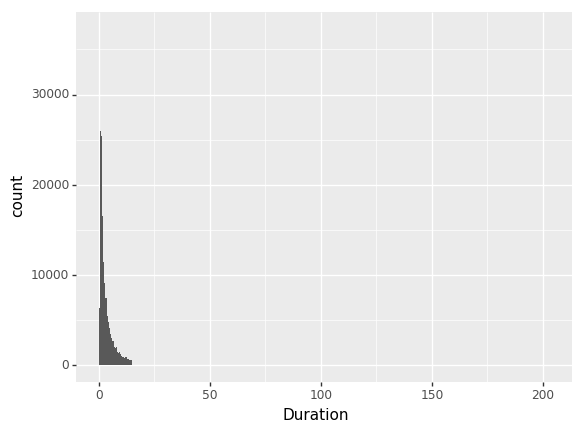

<ggplot: (8793455387968)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 318'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 28 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


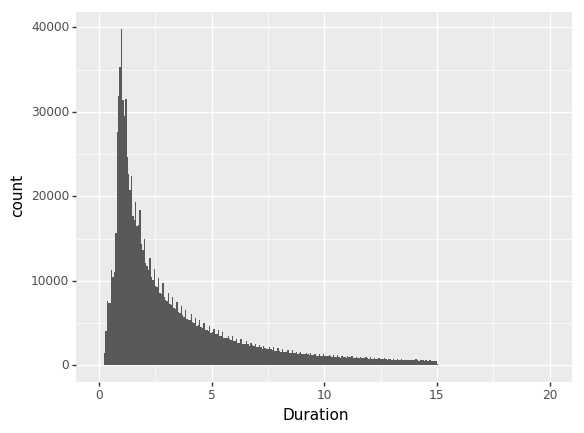

<ggplot: (8793386866366)>

In [81]:
ggplot(durations_df, aes(x="Duration")) + geom_histogram()
# ggplot(durations_df, aes(x="Duration")) + geom_histogram() + xlim(0.0, 20.0)
main_durations_plot = ggplot(durations_df, aes(x="Duration")) + geom_histogram() + xlim(0.0, 20.0)
main_durations_plot

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 419'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


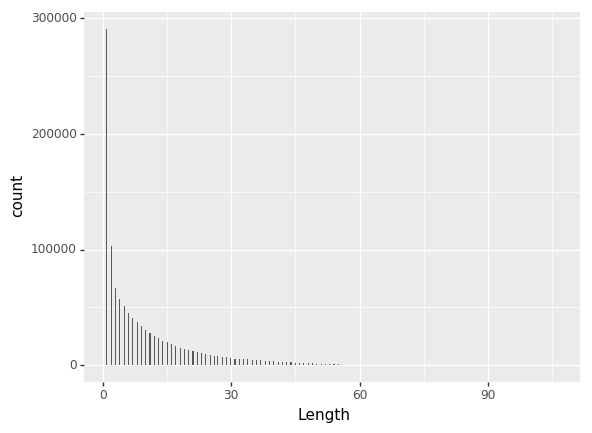

<ggplot: (-9223363243489621595)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 236'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 1271 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


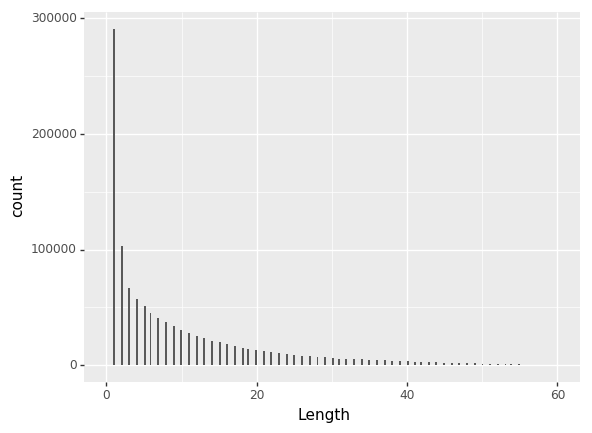

<ggplot: (8793383144617)>

In [82]:
ggplot(lengths_df, aes(x="Length")) + geom_histogram()
# ggplot(lengths_df, aes(x="Length")) + geom_histogram() + xlim(0.0, 60.0)
main_length_plot = ggplot(lengths_df, aes(x="Length")) + geom_histogram() + xlim(0.0, 60.0)
main_length_plot

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 4070'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


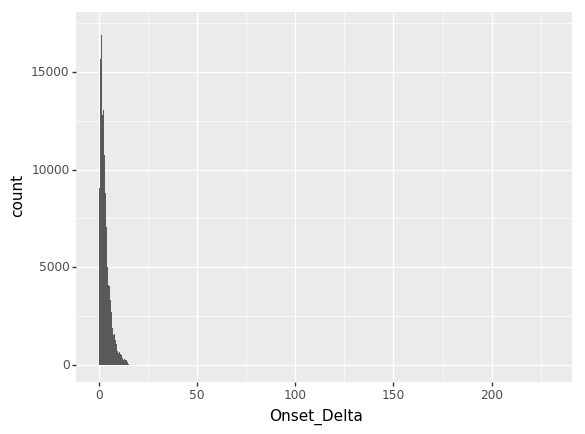

<ggplot: (8793381676671)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 355'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 204 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


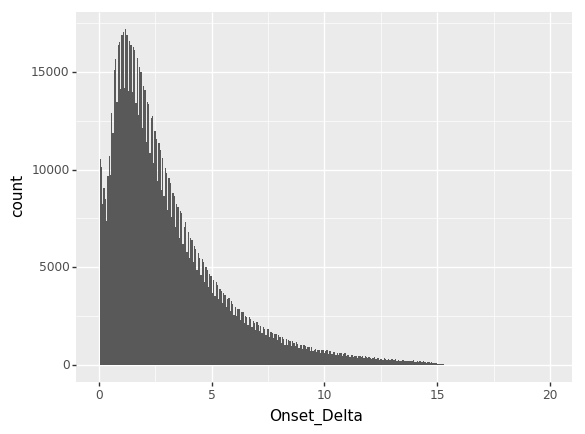

<ggplot: (8793455387968)>

In [83]:
ggplot(onset_deltas_df, aes(x="Onset_Delta")) + geom_histogram()
# ggplot(onset_deltas_df, aes(x="Onset_Delta")) + geom_histogram() + xlim(0.0, 20.0)
main_onset_deltas_plot = ggplot(onset_deltas_df, aes(x="Onset_Delta")) + geom_histogram() + xlim(0.0, 20.0)
main_onset_deltas_plot

## Useful examples

In [84]:
main_transcription_relation[0]

{'speaker': 'A',
 'duration': 4.65,
 'end': 61.03,
 'start': 56.38,
 'speech_raw': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
 'speech': 'i mean no money is very important definitely and a million dollars is a dream come true for me i mean',
 'call_id': '05851',
 'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05851.txt',
 'filename': 'fe_03_05851.txt'}

In [85]:
hasDash = lambda s: '-' in s
tHasDash = lambda t: hasDash(t['speech'])

withDash = list(filter(tHasDash, main_transcription_relation))
len(main_transcription_relation)
len(withDash)
len(withDash) / len(main_transcription_relation)

1113586

24011

0.021561873083892936

In [86]:
hasStartDash = lambda s: ' -' in s
tHasStartDash = lambda t: hasStartDash(t['speech_raw'])

withStartDash = list(filter(tHasStartDash, main_transcription_relation))
len(main_transcription_relation)
len(withDash)
len(withStartDash)
len(withStartDash) / len(withDash)
len(withStartDash) / len(main_transcription_relation)

1113586

24011

864

0.03598350755903544

0.0007758718231012244

In [87]:
getWordsWithStartDash = lambda s: list(filter(lambda s: s[0] == '-', s.split(' ')))
tGetWordsWithStartDash = lambda t: getWordsWithStartDash(t['speech_raw'])

wordsWithStartDash = union(map(lambda t: set(tGetWordsWithStartDash(t)), withStartDash))
len(wordsWithStartDash)
# len(set(wordsWithStartDash))
wordsWithStartDash

211

{'-',
 "-'s",
 '-a',
 '-actly',
 '-adies',
 '-aduated',
 '-ah',
 '-ait',
 '-an',
 '-ana',
 '-ange',
 '-aq',
 '-are',
 '-ass',
 '-at',
 "-at's",
 '-ats',
 '-ave',
 '-ay',
 '-bie',
 '-bio',
 '-body',
 "-body's",
 '-bout',
 '-brate',
 '-burse',
 '-case',
 '-cational',
 '-cause',
 '-cept',
 '-ch',
 '-cher',
 '-chigan',
 '-chusetts',
 '-cially',
 '-construe',
 '-creased',
 '-cross',
 '-culing',
 '-d',
 '-da',
 '-deed',
 '-distribute',
 '-doing',
 '-don',
 '-duced',
 '-e',
 '-e-',
 '-eah',
 '-ean',
 '-eckognize',
 '-ed',
 '-either',
 '-ell',
 '-em',
 '-en',
 '-end',
 '-ends',
 '-er',
 "-ere's",
 '-esh',
 '-est',
 '-ex',
 '-ey',
 '-f',
 '-fenive',
 '-fession',
 '-ff',
 '-fide',
 '-fluenced',
 '-fornia',
 '-freshing',
 '-fused',
 '-gin',
 '-go',
 '-grading',
 '-gratulations',
 '-gree',
 '-greeing',
 '-grees',
 '-gusting',
 '-h',
 '-hand',
 '-hattan',
 '-he',
 '-huh',
 '-i',
 '-ide',
 '-ie',
 '-ight',
 '-ike',
 '-ill',
 '-ing',
 '-instinians',
 '-intentional',
 '-isneyland',
 '-isneyworld',
 '-

In [88]:
from random import choice

In [89]:
choice(withStartDash)

{'speaker': 'A',
 'duration': 5.37,
 'end': 151.91,
 'start': 146.54,
 'speech_raw': "when you go to the basketball court you're going to temple -s what they say [laughter] so wha- d- you like to do",
 'speech': "when you go to the basketball court you're going to temple <rem> what they say so <rem> <rem> you like to do",
 'call_id': '08912',
 'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/089/fe_03_08912.txt',
 'filename': 'fe_03_08912.txt'}

In [90]:
withStartDash[239]
withStartDash[23]

{'speaker': 'B',
 'duration': 5.31,
 'end': 176.69,
 'start': 171.38,
 'speech_raw': 'you re- -distribute and you get more muscle and muscle weighs more than flab',
 'speech': 'you <rem> <rem> and you get more muscle and muscle weighs more than flab',
 'call_id': '08366',
 'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/083/fe_03_08366.txt',
 'filename': 'fe_03_08366.txt'}

{'speaker': 'B',
 'duration': 3.43,
 'end': 159.63,
 'start': 156.2,
 'speech_raw': 'i mean you have to go back and reassure -em and i mean',
 'speech': 'i mean you have to go back and reassure <rem> and i mean',
 'call_id': '05971',
 'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/059/fe_03_05971.txt',
 'filename': 'fe_03_05971.txt'}

**Initialisms**

Initialisms were indicated in the LDC transcripts using periods and underscores:

In [91]:
utts_with_initialisms_main = [t for t in main_transcription_relation if '_' in t['speech']]
len(utts_with_initialisms_main)
utts_with_initialisms_main[:5]

13099

[{'speaker': 'B',
  'duration': 2.67,
  'end': 89.78,
  'start': 87.11,
  'speech_raw': "she's out near l._a. she lives in newport beach",
  'speech': "she's out near l._a. she lives in newport beach",
  'call_id': '05853',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05853.txt',
  'filename': 'fe_03_05853.txt'},
 {'speaker': 'A',
  'duration': 2.41,
  'end': 134.54,
  'start': 132.13,
  'speech_raw': "um i'm a college student at u._c._l._a.",
  'speech': "um i'm a college student at u._c._l._a.",
  'call_id': '05853',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/trans/058/fe_03_05853.txt',
  'filename': 'fe_03_05853.txt'},
 {'speaker': 'B',
  'duration': 3.26,
  'end': 460.76,
  'start': 457.5,
  'speech_raw': 'he um works for an r._v. association',
  'speech': 'he um works for an r._v. association',
  'call_id': '05853',
  'location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tra

# The `bbn` transcriptions

For context, read
 - the last page of Cieri et al. 2004 ("The Fisher Corpus: a Resource for the Next Generations of Speech-to-Text", https://www.ldc.upenn.edu/sites/www.ldc.upenn.edu/files/lrec2004-fisher-corpus.pdf)
 - https://catalog.ldc.upenn.edu/docs/LDC2005T19/bbn_trans_readme.txt

In [92]:
os.chdir(os.path.join(fisher_dir, 'data'))
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data'

In [93]:
%ls

bbn_orig/  trans/


In [94]:
%cd bbn_orig/

/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig


In [95]:
bbn_data_dir = '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig'

In [96]:
%ls

058/  063/  068/  073/  078/  083/  088/  093/  098/  103/  108/  113/
059/  064/  069/  074/  079/  084/  089/  094/  099/  104/  109/
060/  065/  070/  075/  080/  085/  090/  095/  100/  105/  110/
061/  066/  071/  076/  081/  086/  091/  096/  101/  106/  111/
062/  067/  072/  077/  082/  087/  092/  097/  102/  107/  112/


In [97]:
bbn_folders = os.listdir()

In [98]:
os.chdir(os.path.join(bbn_data_dir, '058'))
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058'

In [99]:
%ls

auto-segmented/  originals/  rejected/


Note that, per `https://catalog.ldc.upenn.edu/docs/LDC2005T19/bbn_trans_readme.txt`, 
 - each folder contains a group of (up to?) 100 calls with a shared 3 digit prefix in their call id.
 - subsets 114, 115, and 116 are not here, because those 300 transcripts were done by the LDC.
 
Within each folder, `/originals/` contains `.txo` transcriptions produced by annotators at WordWave; these files were the input to an automatic segmentation process that created the `.ana` and `.trn` files in `/auto-segmented/` folders. `/rejected/` folders contain `.ana` and `.trn` data for utterances that the automatic segmentation process could not handle.

That means the transcription data of interest for this project are in `.trn` files in both `/auto-segmented/` and `/rejected/` folders and will need to be combined.

In [100]:
%cd auto-segmented/

/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented


In [101]:
%ls

fe_03_05863.ana*  fe_03_05876.trn*  fe_03_05888.ana*  fe_03_05889.trn*
fe_03_05863.trn*  fe_03_05887.ana*  fe_03_05888.trn*  fe_03_05898.ana*
fe_03_05876.ana*  fe_03_05887.trn*  fe_03_05889.ana*  fe_03_05898.trn*


In [102]:
%cat -n fe_03_05876.trn | head -20

     1	H- HI THIS IS DEBBIE  (fe_03_05876-A-0001)
     2	HI SYLVIA  (fe_03_05876-A-0002)
     3	[LAUGHTER] I'M JUST TRYING TO GET OVER THIS QUESTION  (fe_03_05876-A-0003)
     4	UH NO IT'S MY SECOND CALL BUT THEY JUST SEEM TO GET MO- [LAUGHTER] MORE AND MORE RIDICULOUS  (fe_03_05876-A-0005)
     5	OH REALLY [LAUGHTER] UM  (fe_03_05876-A-0006)
     6	WELL NO MY BEST FRIEND UM  (fe_03_05876-A-0007)
     7	I DON'T KNOW MY INSTINCT MY INITIAL INSTINCT IS TO SAY NO UH YOU KNOW  (fe_03_05876-A-0008)
     8	HOWEVER I GUESS [LAUGHTER] IF I HAD TO THINK ABOUT IT A WHILE  (fe_03_05876-A-0009)
     9	SEE I COULD DO SO MUCH WITH A MILLION DOLLARS HELP SO MANY PEOPLE BUT [LIPSMACK]  (fe_03_05876-A-0010)
    10	I DON'T KNOW IT JUST DOESN'T IT DOESN'T FEEL RIGHT TO TO TAKE TO HAVE THIS STRING ATTACHED YOU KNOW FIRST OF ALL  (fe_03_05876-A-0011)
    11	[LAUGHTER] SO DO I. THAT'S RIGHT  (fe_03_05876-A-0012)
    12	YOU'RE RIGHT  (fe_03_05876-A-0013)
    13	THAT'S TRUE [NOISE]  (fe_03_05876-A-0014)
    1

## Organizing call transcription files, a unique call ID, and call transcription file location

**Let's create a relation between call id, associated filenames, and locations.**

In [103]:
%cd ..

/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058


In [104]:
%pwd

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058'

In [105]:
%ls

auto-segmented/  originals/  rejected/


In [106]:
set(os.listdir('./auto-segmented/')) == set(os.listdir('./rejected/'))

True

In [107]:
os.listdir('./auto-segmented/')

['fe_03_05863.ana',
 'fe_03_05863.trn',
 'fe_03_05876.ana',
 'fe_03_05876.trn',
 'fe_03_05887.ana',
 'fe_03_05887.trn',
 'fe_03_05888.ana',
 'fe_03_05888.trn',
 'fe_03_05889.ana',
 'fe_03_05889.trn',
 'fe_03_05898.ana',
 'fe_03_05898.trn']

In [108]:
'fe_03_05898.trn'[6:11]

'05898'

In [109]:
def fn_to_call_id_bbn(bbn_fn):
    return bbn_fn[6:11]

In [110]:
def get_call_ids_in_group_dir(group_dir):
    autosegmented_files = set(os.listdir('./auto-segmented/'))
    rejected_files = set(os.listdir('./rejected'))
    autosegmented_call_ids = set(map(fn_to_call_id_bbn,
                                     autosegmented_files))
    rejected_call_ids = set(map(fn_to_call_id_bbn,
                                rejected_files))
    return sorted(list(autosegmented_call_ids | rejected_call_ids))

In [111]:
get_call_ids_in_group_dir('.')

['05863', '05876', '05887', '05888', '05889', '05898']

In [112]:
def call_id_to_relation_bbn(call_id, group_dir):
    fn_prefix = 'fe_03_'
    suffix_a = '.ana'
    suffix_b = '.trn'
    ana_fn = fn_prefix + call_id + suffix_a
    trn_fn = fn_prefix + call_id + suffix_b
    loc_prefix = os.path.join(bbn_data_dir, group_dir)
    return {'call_id':call_id,
            'trn_fn':trn_fn,
            'ana_fn':ana_fn,
            'auto-segmented_trn_location':os.path.join(loc_prefix, 'auto-segmented/' + trn_fn),
            'rejected_trn_location':os.path.join(loc_prefix, 'rejected/' + trn_fn) if os.path.isfile(os.path.join(loc_prefix, 'rejected/' + trn_fn)) else '',
            'auto-segmented_ana_location':os.path.join(loc_prefix, 'auto-segmented/' + ana_fn),
            'rejected_ana_location':os.path.join(loc_prefix, 'rejected/' + ana_fn) if os.path.isfile(os.path.join(loc_prefix, 'rejected/' + ana_fn)) else '',}

In [113]:
%pwd

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058'

In [114]:
os.listdir('./auto-segmented/')
os.listdir('./rejected/')

['fe_03_05863.ana',
 'fe_03_05863.trn',
 'fe_03_05876.ana',
 'fe_03_05876.trn',
 'fe_03_05887.ana',
 'fe_03_05887.trn',
 'fe_03_05888.ana',
 'fe_03_05888.trn',
 'fe_03_05889.ana',
 'fe_03_05889.trn',
 'fe_03_05898.ana',
 'fe_03_05898.trn']

['fe_03_05863.ana',
 'fe_03_05863.trn',
 'fe_03_05876.ana',
 'fe_03_05876.trn',
 'fe_03_05887.ana',
 'fe_03_05887.trn',
 'fe_03_05888.ana',
 'fe_03_05888.trn',
 'fe_03_05889.ana',
 'fe_03_05889.trn',
 'fe_03_05898.ana',
 'fe_03_05898.trn']

In [115]:
call_id_to_relation_bbn('05863', '058')

loc = call_id_to_relation_bbn('05863', '058')['auto-segmented_trn_location']
loc

{'call_id': '05863',
 'trn_fn': 'fe_03_05863.trn',
 'ana_fn': 'fe_03_05863.ana',
 'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn',
 'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn',
 'auto-segmented_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.ana',
 'rejected_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana'}

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn'

In [116]:
os.chdir(bbn_data_dir)
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig'

In [117]:
bbn_call_relation = []
for folder in bbn_folders:
    os.chdir(folder)
    for call_id in get_call_ids_in_group_dir('.'):
        bbn_call_relation.append(call_id_to_relation_bbn(call_id, folder))
    os.chdir('..')

In [118]:
bbn_call_relation[:3]

[{'call_id': '05863',
  'trn_fn': 'fe_03_05863.trn',
  'ana_fn': 'fe_03_05863.ana',
  'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn',
  'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn',
  'auto-segmented_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.ana',
  'rejected_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana'},
 {'call_id': '05876',
  'trn_fn': 'fe_03_05876.trn',
  'ana_fn': 'fe_03_05876.ana',
  'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05876.trn',
  'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_

## Organizing transcriptions of each call

In [119]:
os.chdir(os.path.join(bbn_data_dir, '058'))
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058'

In [120]:
%ls auto-segmented/

fe_03_05863.ana*  fe_03_05876.trn*  fe_03_05888.ana*  fe_03_05889.trn*
fe_03_05863.trn*  fe_03_05887.ana*  fe_03_05888.trn*  fe_03_05898.ana*
fe_03_05876.ana*  fe_03_05887.trn*  fe_03_05889.ana*  fe_03_05898.trn*


#### Parsing transcription lines

In [121]:
%cat -n ./auto-segmented/fe_03_05863.trn | head -25

     1	HI [LAUGHTER]  (fe_03_05863-A-0001)
     2	HI MY NAME IS ZELDA  (fe_03_05863-A-0002)
     3	HI MONIQUE  (fe_03_05863-A-0003)
     4	I'M FINE AND YOU  (fe_03_05863-A-0004)
     5	GOOD  (fe_03_05863-A-0005)
     6	OKAY UM  (fe_03_05863-A-0006)
     7	I WOULD NOT DO IT  (fe_03_05863-A-0007)
     8	[NOISE] RIGHT I WOULDN'T UM DO YOU KID- ESP- UH TODAY I MEAN  (fe_03_05863-A-0008)
     9	PEOPLE LOOK AT MONEY MONEY IS EVERYTHING IT'S LIKE THEY THINK THAT MONEY'S GOING TO RESOLVE ALL THEIR PROBLEMS AND A MILLION DOLLARS TODAY IS NOT A LOT OF MONEY AND I WOULD AND THAT'S A BETRAYAL TO ME [NOISE]  (fe_03_05863-A-0009)
    10	RIGHT RIGHT  (fe_03_05863-A-0010)
    11	NO  (fe_03_05863-A-0011)
    12	I THINK HUMAN BEINGS ARE PR- UM [LIPSMACK] FRIENDSHIP RELAT- RELATIONSHIPS WITH PEOPLE ARE A LOT MORE IMPORTANT THAN MONEY  (fe_03_05863-A-0012)
    13	THEN YOU WEREN'T REALLY THEIR BEST FRIEND EITHER  (fe_03_05863-A-0013)
    14	RIGHT RIGHT  (fe_03_05863-A-0014)
    15	NO  (fe_03_05863-A-0015)


In [122]:
%cat -n ./rejected/fe_03_05863.trn | head -20

     1	BUT UM (fe_03_05863-A-0021)
     2	NO NO (fe_03_05863-A-0045)
     3	UM (fe_03_05863-A-0065)
     4	[LIPSMACK] OH (fe_03_05863-A-0066)
     5	REALLY (fe_03_05863-A-0105)
     6	YEAH MHM (fe_03_05863-A-0109)
     7	THAT'S WHAT I SAY MHM (fe_03_05863-A-0113)
     8	YOU KNOW (fe_03_05863-A-0121)
     9	YEAH (fe_03_05863-A-0122)
    10	ON ME THERE OOH THAT'S WHY UM I'M I'M LOSING YA (fe_03_05863-A-0125)
    11	[NOISE] HELLO HOW ARE YOU DOING MY (fe_03_05863-B-0002)
    12	HOW'RE YOU DOING (fe_03_05863-B-0004)
    13	MM MM (fe_03_05863-B-0019)
    14	[LAUGHTER] OH BOY [SIGH] (fe_03_05863-B-0021)
    15	LET'S SEE LET'S SEE (fe_03_05863-B-0022)
    16	YOU KNOW (fe_03_05863-B-0027)
    17	[NOISE] (fe_03_05863-B-0029)
    18	UH-HUH (fe_03_05863-B-0034)
    19	YOU LIVE IN CALIFORNIA (fe_03_05863-B-0039)
    20	MAN (fe_03_05863-B-0045)


As indicated in `https://catalog.ldc.upenn.edu/docs/LDC2005T19/bbn_trans_readme.txt`, `.trn` files are in .SNOR format:
 - mono-case with no syntactic punctuation
 - each line is one "utterance"
 - each line ends with a unique utterance ID in parentheses

Non-speech noises seem to be indicated by square brackets (e.g. `[LAUGHTER]`).

In [123]:
def parse_trn_line_bbn(bbn_line):
    parts = bbn_line.split(' ')
    
#     utterance_id = parts[-1]
    utterance_id = parts[-1][1:-1] #strip parentheses off
    
    speech_raw_words = parts[:-1]
    speech_raw = ' '.join(speech_raw_words)
    speech_raw = speech_raw.rstrip()
    
    if utterance_id == "(fe_03_07397-A-0028":
        utterance_id = "fe_03_07397-A-0028"
        speech_raw_words += ['S']
        speech_raw += ' S'
    elif utterance_id == "(fe_03_10453-A-0023":
        utterance_id = "fe_03_10453-A-0023"
        speech_raw_words += ['S']
        speech_raw += ' S'
    
#     speech_filtered_words = [w for w in speech_raw_words if len(w) > 0 and w[0] != '[' and w[-1] != ']']
#     speech = ' '.join(speech_filtered_words)
#     speech = speech.rstrip()
    speech = process(speech_raw)
        
    line_rel = {'speech_raw':speech_raw,
                'speech':speech,
                'n_words':len(speech.split(' ')),
                'has_words': False if speech == '' else True,
                'utterance_id':utterance_id,
                'call_id':utterance_id[6:11],
                'speaker':utterance_id[12:13]}
    
    return line_rel

parse_trn_line_bbn('[LAUGHTER] OH BOY [SIGH] (fe_03_05863-B-0021)')
parse_trn_line_bbn("[LAUGHTER] THE DEAD S(fe_03_10453-A-0023)")

{'speech_raw': '[LAUGHTER] OH BOY [SIGH]',
 'speech': 'oh boy',
 'n_words': 2,
 'has_words': True,
 'utterance_id': 'fe_03_05863-B-0021',
 'call_id': '05863',
 'speaker': 'B'}

{'speech_raw': '[LAUGHTER] THE DEAD S',
 'speech': 'the dead s',
 'n_words': 3,
 'has_words': True,
 'utterance_id': 'fe_03_10453-A-0023',
 'call_id': '10453',
 'speaker': 'A'}

In [124]:
"fe_03_10453-A-0023"[6:11]
"fe_03_10453-A-0023"[12:13]

'10453'

'A'

As indicated in `https://catalog.ldc.upenn.edu/docs/LDC2005T19/bbn_trans_readme.txt`, each line of an `.ana` file indicates the start and end times (in samples) of each utterance:
 - the last column is an utterance id
 - the second or third from last column indicates the sample range of the utterance

In [125]:
%cat -n ./rejected/fe_03_05863.ana | head -20

     1	fe_03_05863 -c 1 -t NIST_1A -f 966480-974640 -o fe_03_05863-A-0021
     2	fe_03_05863 -c 1 -t NIST_1A -f 1821360-1826880 -o fe_03_05863-A-0045
     3	fe_03_05863 -c 1 -t NIST_1A -f 2573120-2579840 -o fe_03_05863-A-0065
     4	fe_03_05863 -c 1 -t NIST_1A -f 2592080-2598160 -o fe_03_05863-A-0066
     5	fe_03_05863 -c 1 -t NIST_1A -f 4225360-4233200 -o fe_03_05863-A-0105
     6	fe_03_05863 -c 1 -t NIST_1A -f 4392240-4404720 -o fe_03_05863-A-0109
     7	fe_03_05863 -c 1 -t NIST_1A -f 4482880-4492720 -o fe_03_05863-A-0113
     8	fe_03_05863 -c 1 -t NIST_1A -f 4687600-4694240 -o fe_03_05863-A-0121
     9	fe_03_05863 -c 1 -t NIST_1A -f 4702240-4710880 -o fe_03_05863-A-0122
    10	fe_03_05863 -c 1 -t NIST_1A -f 4772000-4799200 -o fe_03_05863-A-0125
    11	fe_03_05863 -c 2 -t NIST_1A -f 20240-32480 -o fe_03_05863-B-0002
    12	fe_03_05863 -c 2 -t NIST_1A -f 71360-80240 -o fe_03_05863-B-0004
    13	fe_03_05863 -c 2 -t NIST_1A -f 755440-762000 -o fe_03_05863-B-0019
    14	fe_03_05863 -c 2 

In [126]:
"fe_03_05863 -c 2 -t NIST_1A -f 1829200-1836720 -o fe_03_05863-B-0045".split(' ')
"fe_03_05863 -c 2 -t NIST_1A -f 1829200-1836720 -o fe_03_05863-B-0045".split(' ')[-3]
"fe_03_05863 -c 2 -t NIST_1A -f 1829200-1836720 -o fe_03_05863-B-0045".split(' ')[-3].split('-')

['fe_03_05863',
 '-c',
 '2',
 '-t',
 'NIST_1A',
 '-f',
 '1829200-1836720',
 '-o',
 'fe_03_05863-B-0045']

'1829200-1836720'

['1829200', '1836720']

In [127]:
def parse_ana_line_bbn(bbn_line):
    parts = bbn_line.split(' ')
    
#     utterance_id = parts[-1]
    utterance_id = parts[-1]
    
    audio_ext = '.sph'
    audio_fn = parts[0] + audio_ext
    
    channel = int(parts[2])
    
    ch_type = parts[4]
    
    utterance_sample_range = parts[-3]
    
    start_sample = int(utterance_sample_range.split('-')[0])
    end_sample = int(utterance_sample_range.split('-')[1])
    duration = end_sample - start_sample
    
    line_rel = {'utterance_id':utterance_id,
                'start':start_sample,
                'end':end_sample,
                'duration':duration,
                'audio_fn':audio_fn,
                'channel':channel,
                'type':ch_type}
    
    return line_rel

parse_ana_line_bbn("fe_03_05863 -c 2 -t NIST_1A -f 1829200-1836720 -o fe_03_05863-B-0045")

{'utterance_id': 'fe_03_05863-B-0045',
 'start': 1829200,
 'end': 1836720,
 'duration': 7520,
 'audio_fn': 'fe_03_05863.sph',
 'channel': 2,
 'type': 'NIST_1A'}

### Parsing files

In [128]:
def parse_trn_file_bbn(bbn_fp):
    bbn_lines = []
    with open(bbn_fp, 'r') as file:
        for line in file:
            bbn_lines.append(line.rstrip())
    parsed_lines = [parse_trn_line_bbn(l) for l in bbn_lines]
    return parsed_lines

In [129]:
%pwd

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058'

In [130]:
%ls ./auto-segmented

fe_03_05863.ana*  fe_03_05876.trn*  fe_03_05888.ana*  fe_03_05889.trn*
fe_03_05863.trn*  fe_03_05887.ana*  fe_03_05888.trn*  fe_03_05898.ana*
fe_03_05876.ana*  fe_03_05887.trn*  fe_03_05889.ana*  fe_03_05898.trn*


In [131]:
parse_trn_file_bbn('./auto-segmented/fe_03_05876.trn')

[{'speech_raw': 'H- HI THIS IS DEBBIE',
  'speech': '<rem> hi this is debbie',
  'n_words': 5,
  'has_words': True,
  'utterance_id': 'fe_03_05876-A-0001',
  'call_id': '05876',
  'speaker': 'A'},
 {'speech_raw': 'HI SYLVIA',
  'speech': 'hi sylvia',
  'n_words': 2,
  'has_words': True,
  'utterance_id': 'fe_03_05876-A-0002',
  'call_id': '05876',
  'speaker': 'A'},
 {'speech_raw': "[LAUGHTER] I'M JUST TRYING TO GET OVER THIS QUESTION",
  'speech': "i'm just trying to get over this question",
  'n_words': 8,
  'has_words': True,
  'utterance_id': 'fe_03_05876-A-0003',
  'call_id': '05876',
  'speaker': 'A'},
 {'speech_raw': "UH NO IT'S MY SECOND CALL BUT THEY JUST SEEM TO GET MO- [LAUGHTER] MORE AND MORE RIDICULOUS",
  'speech': "uh no it's my second call but they just seem to get <rem> more and more ridiculous",
  'n_words': 17,
  'has_words': True,
  'utterance_id': 'fe_03_05876-A-0005',
  'call_id': '05876',
  'speaker': 'A'},
 {'speech_raw': 'OH REALLY [LAUGHTER] UM',
  'speech': '

limit_output extension: Maximum message size of 20000 exceeded with 46743 characters

In [132]:
def parse_ana_file_bbn(bbn_fp):
    bbn_lines = []
    with open(bbn_fp, 'r') as file:
        for line in file:
            bbn_lines.append(line.rstrip())
    parsed_lines = [parse_ana_line_bbn(l) for l in bbn_lines]
    return parsed_lines

In [133]:
parse_ana_file_bbn('./auto-segmented/fe_03_05876.ana')

[{'utterance_id': 'fe_03_05876-A-0001',
  'start': 19360,
  'end': 33280,
  'duration': 13920,
  'audio_fn': 'fe_03_05876.sph',
  'channel': 1,
  'type': 'NIST_1A'},
 {'utterance_id': 'fe_03_05876-A-0002',
  'start': 39280,
  'end': 50880,
  'duration': 11600,
  'audio_fn': 'fe_03_05876.sph',
  'channel': 1,
  'type': 'NIST_1A'},
 {'utterance_id': 'fe_03_05876-A-0003',
  'start': 54720,
  'end': 80080,
  'duration': 25360,
  'audio_fn': 'fe_03_05876.sph',
  'channel': 1,
  'type': 'NIST_1A'},
 {'utterance_id': 'fe_03_05876-A-0005',
  'start': 94160,
  'end': 131360,
  'duration': 37200,
  'audio_fn': 'fe_03_05876.sph',
  'channel': 1,
  'type': 'NIST_1A'},
 {'utterance_id': 'fe_03_05876-A-0006',
  'start': 140400,
  'end': 161200,
  'duration': 20800,
  'audio_fn': 'fe_03_05876.sph',
  'channel': 1,
  'type': 'NIST_1A'},
 {'utterance_id': 'fe_03_05876-A-0007',
  'start': 180480,
  'end': 215200,
  'duration': 34720,
  'audio_fn': 'fe_03_05876.sph',
  'channel': 1,
  'type': 'NIST_1A'},

limit_output extension: Maximum message size of 20000 exceeded with 27931 characters

### Creating merged representations of each call

In [134]:
#create merged representation of conversation from auto-segmented and rejected .trn and .ana files, sort utterances by utterance ID

In [135]:
bbn_call_relation[0]

{'call_id': '05863',
 'trn_fn': 'fe_03_05863.trn',
 'ana_fn': 'fe_03_05863.ana',
 'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn',
 'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn',
 'auto-segmented_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.ana',
 'rejected_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana'}

In [136]:
def get_transcriptions_bbn(call_id):
    call_relation_matches = [c for c in bbn_call_relation if c['call_id'] == call_id]
    assert len(call_relation_matches) == 1, 'call id {0} does not have exactly 1 match, but rather {1}'.format(call_id, call_relation_matches)
    call_rel = call_relation_matches[0]
    
    as_trn = parse_trn_file_bbn(call_rel['auto-segmented_trn_location'])
    r_trn = parse_trn_file_bbn(call_rel['rejected_trn_location'])
    merged_trn = sorted(as_trn + r_trn, key=lambda t_rel: t_rel['utterance_id'])
    
    as_ana = parse_ana_file_bbn(call_rel['auto-segmented_ana_location'])
    r_ana = parse_ana_file_bbn(call_rel['rejected_ana_location'])
    merged_ana = sorted(as_ana + r_ana, key=lambda ana_rel: ana_rel['utterance_id'])
    
    assert len(merged_trn) == len(merged_ana), 'merged trn and merged ana utterance sequences differ in length: {0} vs. {1}'.format(len(merged_trn), len(merged_ana))
    
    utterance_ids = [t_rel['utterance_id'] for t_rel in merged_trn]
    merged_rels = []
    for u_id in utterance_ids:
        matching_trns = [trn_rel for trn_rel in merged_trn if trn_rel['utterance_id'] == u_id]
        assert len(matching_trns) == 1, 'Utterance id {0} does not have exactly one matching trn relation, instead has {1}'.format(u_id, matching_trns)
        trn_rel = matching_trns[0]
        
        matching_anas = [ana_rel for ana_rel in merged_ana if ana_rel['utterance_id'] == u_id]
        assert len(matching_anas) == 1, 'Utterance id {0} does not have exactly one matching ana relation, instead has {1}'.format(u_id, matching_anas)
        ana_rel = matching_anas[0]
        
        merged_rel = dictionary_product(trn_rel, ana_rel)
        merged_rels.append(merged_rel)
    
    return merged_rels

In [137]:
get_transcriptions_bbn('05863')

[{'speaker': 'A',
  'n_words': 1,
  'call_id': '05863',
  'utterance_id': 'fe_03_05863-A-0001',
  'speech_raw': 'HI [LAUGHTER]',
  'has_words': True,
  'speech': 'hi',
  'duration': 10960,
  'end': 12320,
  'start': 1360,
  'channel': 1,
  'audio_fn': 'fe_03_05863.sph',
  'type': 'NIST_1A'},
 {'speaker': 'A',
  'n_words': 5,
  'call_id': '05863',
  'utterance_id': 'fe_03_05863-A-0002',
  'speech_raw': 'HI MY NAME IS ZELDA',
  'has_words': True,
  'speech': 'hi my name is zelda',
  'duration': 14080,
  'end': 46640,
  'start': 32560,
  'channel': 1,
  'audio_fn': 'fe_03_05863.sph',
  'type': 'NIST_1A'},
 {'speaker': 'A',
  'n_words': 2,
  'call_id': '05863',
  'utterance_id': 'fe_03_05863-A-0003',
  'speech_raw': 'HI MONIQUE',
  'has_words': True,
  'speech': 'hi monique',
  'duration': 10000,
  'end': 69760,
  'start': 59760,
  'channel': 1,
  'audio_fn': 'fe_03_05863.sph',
  'type': 'NIST_1A'},
 {'speaker': 'A',
  'n_words': 4,
  'call_id': '05863',
  'utterance_id': 'fe_03_05863-A-00

limit_output extension: Maximum message size of 20000 exceeded with 80107 characters

## Some summary / sanity-checking statistics

How many calls are in the bbn transcripts?

In [138]:
call_ids_bbn = [c['call_id'] for c in bbn_call_relation]
len(call_ids_bbn)
len(call_ids)
len(call_ids) - len(call_ids_bbn)

5120

5849

729

In [139]:
set(call_ids) - set(call_ids_bbn)

{'05851',
 '05852',
 '05853',
 '05854',
 '05855',
 '05856',
 '05857',
 '05858',
 '05859',
 '05860',
 '05861',
 '05862',
 '05864',
 '05865',
 '05866',
 '05867',
 '05868',
 '05869',
 '05870',
 '05871',
 '05872',
 '05873',
 '05874',
 '05875',
 '05877',
 '05878',
 '05879',
 '05880',
 '05881',
 '05882',
 '05883',
 '05884',
 '05885',
 '05886',
 '05890',
 '05891',
 '05892',
 '05893',
 '05894',
 '05895',
 '05896',
 '05897',
 '05899',
 '05900',
 '05901',
 '05902',
 '05903',
 '05904',
 '05905',
 '05906',
 '05907',
 '05908',
 '05909',
 '05910',
 '05911',
 '05912',
 '05913',
 '05914',
 '05915',
 '05916',
 '05917',
 '05918',
 '05919',
 '05920',
 '05921',
 '05922',
 '05923',
 '05924',
 '05925',
 '05926',
 '05927',
 '05928',
 '05929',
 '05930',
 '05931',
 '05932',
 '05933',
 '05934',
 '05935',
 '05936',
 '05937',
 '05938',
 '05939',
 '05940',
 '05941',
 '05942',
 '05943',
 '05944',
 '05945',
 '05946',
 '05947',
 '05948',
 '05949',
 '05950',
 '05951',
 '05952',
 '05953',
 '05954',
 '05955',
 '05956',


According to the documentation, only 300 conversations should be missing from the `bbn` transcriptions - those prefixed with `114`, `115`, and `116`. What's the story on the other 429????

How many word tokens are in the `bbn` transcripts?

In [140]:
def count_word_tokens_in_call_bbn(call_id):
    return sum([count_word_tokens_in_line(l) for l in get_transcriptions_bbn(call_id)])

#31.0s on wittgenstein
# sum([count_word_tokens_in_call_bbn(call_id) for call_id in call_ids_bbn])

#vs. 5.5s on wittgenstein
sum(par(delayed(count_word_tokens_in_call_bbn)(call_id)
        for call_id in call_ids_bbn))

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0185s.) Setting batch_size=20.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 270 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done 530 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done 790 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done 1090 tasks      | elapsed:    1.4s
[Parallel(n_jobs=15)]: Done 1390 tasks      | elapsed:    1.7s
[Parallel(n_jobs=15)]: Done 1730 tasks      | elapsed:    2.0s
[Parallel(n_jobs=15)]: Done 2070 tasks      | elapsed:    2.4s
[Parallel(n_jobs=15)]: Done 2450 tasks      | elapsed:    2.8s
[Parallel(n_jobs=15)]: Done 2830 tasks      | elapsed:    3.1s
[Parallel(n_jobs

9676792

How many word types are in the `bbn` transcripts?

In [141]:
def word_types_in_call_bbn(call_id):
    return union([word_types_in_line(l) for l in get_transcriptions_bbn(call_id)])

#42.2s on wittgenstein
# vocabulary_bbn = union([word_types_in_call_bbn(c) for c in call_ids_bbn])
# len(vocabulary_bbn)

# vs.  5.8s on wittgenstein
vocabulary_bbn = union(par(delayed(word_types_in_call_bbn)(c) for c in call_ids_bbn))
len(vocabulary_bbn)

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0204s.) Setting batch_size=18.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  48 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 246 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done 480 tasks      | elapsed:    0.8s
[Parallel(n_jobs=15)]: Done 714 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done 984 tasks      | elapsed:    1.4s
[Parallel(n_jobs=15)]: Done 1254 tasks      | elapsed:    1.7s
[Parallel(n_jobs=15)]: Done 1560 tasks      | elapsed:    2.1s
[Parallel(n_jobs=15)]: Done 1866 tasks      | elapsed:    2.5s
[Parallel(n_jobs=15)]: Done 2208 tasks      | elapsed:    2.8s
[Parallel(n_jobs=15)]: Done 2550 tasks      | elapsed:    3.2s
[Parallel(n_jobs=

42014

In [142]:
list(vocabulary_bbn)[:100]

['',
 'sewing',
 'internationally',
 'paralegal',
 'obstinate',
 'bolingbrook',
 'pussycat',
 'spent',
 'refreshment',
 'pleasantries',
 'resurfaces',
 'water',
 'sideline',
 'dabbled',
 'malfunctions',
 'reacher',
 "officers'",
 'goodie',
 'flecks',
 'centigrade',
 'overtimes',
 'trail',
 'hibernation',
 'hiya',
 'daughter',
 'laureates',
 'farmer',
 'beaming',
 'geek',
 'crosses',
 'proper',
 'salary',
 'freezer',
 'partaking',
 'hunting',
 'embodied',
 'wailing',
 'genocide',
 'summertime',
 'roofs',
 'pertain',
 'gunshot',
 'commodity',
 'glider',
 'bricklayer',
 'clanton',
 'trickled',
 'melba',
 'farrelly',
 'utopian',
 'derrick',
 'grossness',
 'rightly',
 'satisfies',
 'squeaks',
 'climax',
 'waseeka',
 'handicapped',
 'leaguers',
 'salutations',
 'smallest',
 'pedophilia',
 "patterson's",
 'without',
 'map',
 'hoy',
 'knoxville',
 'battered',
 'dimensions',
 'dapple',
 'freebies',
 'betterer',
 'introverts',
 'volleyball',
 'sheeting',
 'vitamins',
 'culturally',
 'athleticall

In [143]:
vocabulary_bbn_alpha = sorted(list(vocabulary_bbn))
vocabulary_bbn_alpha[:10]

['',
 "'and",
 "'berserkly'",
 "'bout",
 "'burb",
 "'burban",
 "'burbs",
 "'cau",
 "'cause",
 "'cept"]

In [144]:
%%capture
#cell magic above suppresses useless output of file.write

vocabulary_bbn_fn = 'fisher_vocabulary_bbn.txt'

vocabulary_bbn_fp = os.path.join(repo_dir, vocabulary_bbn_fn)

#5.02s on wittgenstein
with open(vocabulary_bbn_fp, 'w') as file:
    for w in vocabulary_bbn_alpha:
        file.write("{0}\n".format(w));

In [145]:
%cat -n /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_vocabulary_bbn.txt | head -20

     1	
     2	'and
     3	'berserkly'
     4	'bout
     5	'burb
     6	'burban
     7	'burbs
     8	'cau
     9	'cause
    10	'cept
    11	'cide
    12	'cisco
    13	'cize
    14	'course
    15	'cuse
    16	'do
    17	'em
    18	'em's
    19	'ems
    20	'everybody's
cat: write error: Broken pipe


## Naive utterance sequence

In [146]:
def get_utterances_from_call_bbn(call_id):
    return [l['speech'] for l in get_transcriptions_bbn(call_id)]

In [147]:
call_ids_bbn[0]

'05863'

In [148]:
get_utterances_from_call_bbn('05863')[:10]

['hi',
 'hi my name is zelda',
 'hi monique',
 "i'm fine and you",
 'good',
 'okay um',
 'i would not do it',
 "right i wouldn't um do you <rem> <rem> uh today i mean",
 "people look at money money is everything it's like they think that money's going to resolve all their problems and a million dollars today is not a lot of money and i would and that's a betrayal to me",
 'right right']

In [149]:
#35.3s on wittgenstein
# utterances_bbn = []
# for c in call_ids_bbn:
#     utterances_bbn.extend( get_utterances_from_call_bbn(c) )
# len(utterances_bbn)

# 5.5s on wittgenstein
utterances_bbn = list(chain.from_iterable(par(delayed(get_utterances_from_call_bbn)(c)
                                              for c in call_ids_bbn)))
len(utterances_bbn)

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0196s.) Setting batch_size=20.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 270 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done 530 tasks      | elapsed:    0.8s
[Parallel(n_jobs=15)]: Done 790 tasks      | elapsed:    1.0s
[Parallel(n_jobs=15)]: Done 1090 tasks      | elapsed:    1.3s
[Parallel(n_jobs=15)]: Done 1390 tasks      | elapsed:    1.6s
[Parallel(n_jobs=15)]: Done 1730 tasks      | elapsed:    2.0s
[Parallel(n_jobs=15)]: Done 2070 tasks      | elapsed:    2.3s
[Parallel(n_jobs=15)]: Done 2450 tasks      | elapsed:    2.8s
[Parallel(n_jobs=15)]: Done 2830 tasks      | elapsed:    3.3s
[Parallel(n_jobs

954017

In [150]:
utterances_bbn[0]

'hi'

In [151]:
%%capture
#cell magic above suppresses useless output of file.write

fisher_utterances_bbn_fn = 'fisher_utterances_bbn.txt'

fisher_utterances_bbn_path = os.path.join(repo_dir, fisher_utterances_bbn_fn)


with open(fisher_utterances_bbn_path, 'w') as file:

    #write all lines at once using writelines and this takes <1s
    utterances_w_linebreaks = list(map(lambda l: l + "\n", utterances_bbn))
    file.writelines(utterances_w_linebreaks)
    
    #if someone else is using the machine heavily doing other things, this can take upwards of 2ms
#     for utterance in utterances_bbn:
#         file.write("{0}\n".format(utterance));

In [152]:
%cat -n /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_bbn.txt | head -20

     1	hi
     2	hi my name is zelda
     3	hi monique
     4	i'm fine and you
     5	good
     6	okay um
     7	i would not do it
     8	right i wouldn't um do you <rem> <rem> uh today i mean
     9	people look at money money is everything it's like they think that money's going to resolve all their problems and a million dollars today is not a lot of money and i would and that's a betrayal to me
    10	right right
    11	no
    12	i think human beings are <rem> um friendship <rem> relationships with people are a lot more important than money
    13	then you weren't really their best friend either
    14	right right
    15	no
    16	mm
    17	i don't think any money is worth anyone's life uh a human a person's life is worth everything
    18	amen is right
    19	i mean <rem> there's not really much that we can debate on this because we really agreed on it you know
    20	right
cat: write error: Broken pipe


## All transcriptions

In [153]:
bbn_call_relation[:3]

[{'call_id': '05863',
  'trn_fn': 'fe_03_05863.trn',
  'ana_fn': 'fe_03_05863.ana',
  'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn',
  'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn',
  'auto-segmented_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.ana',
  'rejected_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana'},
 {'call_id': '05876',
  'trn_fn': 'fe_03_05876.trn',
  'ana_fn': 'fe_03_05876.ana',
  'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05876.trn',
  'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_

In [154]:
call_ids_bbn[:3]

['05863', '05876', '05887']

In [155]:
get_transcriptions_bbn('05863')[:3]

[{'speaker': 'A',
  'n_words': 1,
  'call_id': '05863',
  'utterance_id': 'fe_03_05863-A-0001',
  'speech_raw': 'HI [LAUGHTER]',
  'has_words': True,
  'speech': 'hi',
  'duration': 10960,
  'end': 12320,
  'start': 1360,
  'channel': 1,
  'audio_fn': 'fe_03_05863.sph',
  'type': 'NIST_1A'},
 {'speaker': 'A',
  'n_words': 5,
  'call_id': '05863',
  'utterance_id': 'fe_03_05863-A-0002',
  'speech_raw': 'HI MY NAME IS ZELDA',
  'has_words': True,
  'speech': 'hi my name is zelda',
  'duration': 14080,
  'end': 46640,
  'start': 32560,
  'channel': 1,
  'audio_fn': 'fe_03_05863.sph',
  'type': 'NIST_1A'},
 {'speaker': 'A',
  'n_words': 2,
  'call_id': '05863',
  'utterance_id': 'fe_03_05863-A-0003',
  'speech_raw': 'HI MONIQUE',
  'has_words': True,
  'speech': 'hi monique',
  'duration': 10000,
  'end': 69760,
  'start': 59760,
  'channel': 1,
  'audio_fn': 'fe_03_05863.sph',
  'type': 'NIST_1A'}]

In [156]:
bbn_call_relation[0]

{'call_id': '05863',
 'trn_fn': 'fe_03_05863.trn',
 'ana_fn': 'fe_03_05863.ana',
 'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn',
 'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn',
 'auto-segmented_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.ana',
 'rejected_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana'}

In [157]:
#39.0s on wittgenstein
# bbn_transcription_relation = []
# for call_relation in bbn_call_relation:
#     for transcription_relation in get_transcriptions_bbn(call_relation['call_id']):
#         new_transcription_rel = dictionary_product(transcription_relation, call_relation)
#         bbn_transcription_relation.append(new_transcription_rel)

# 6.9s on wittgenstein
def get_bbn_transcription_relation_for(call_rel):
#     return par(delayed(dictionary_product)(transcription_relation, call_rel)
#                for transcription_relation in get_transcriptions_bbn(call_rel['call_id']))
    return [dictionary_product(transcription_relation, call_rel)
           for transcription_relation in get_transcriptions_bbn(call_rel['call_id'])]

bbn_transcription_relation = list(chain.from_iterable(par(delayed(get_bbn_transcription_relation_for)(call_relation)
                                                          for call_relation in bbn_call_relation)))

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0255s.) Setting batch_size=14.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 198 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 380 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done 562 tasks      | elapsed:    0.9s
[Parallel(n_jobs=15)]: Done 772 tasks      | elapsed:    1.2s
[Parallel(n_jobs=15)]: Done 982 tasks      | elapsed:    1.4s
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:    1.7s
[Parallel(n_jobs=15)]: Done 1458 tasks      | elapsed:    2.1s
[Parallel(n_jobs=15)]: Done 1724 tasks      | elapsed:    2.4s
[Parallel(n_jobs=15)]: Done 1990 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1

In [158]:
len(bbn_transcription_relation)

954017

In [159]:
bbn_transcription_relation[:5]

[{'speaker': 'A',
  'n_words': 1,
  'duration': 10960,
  'call_id': '05863',
  'utterance_id': 'fe_03_05863-A-0001',
  'speech_raw': 'HI [LAUGHTER]',
  'end': 12320,
  'start': 1360,
  'audio_fn': 'fe_03_05863.sph',
  'channel': 1,
  'has_words': True,
  'type': 'NIST_1A',
  'speech': 'hi',
  'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn',
  'rejected_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana',
  'ana_fn': 'fe_03_05863.ana',
  'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn',
  'trn_fn': 'fe_03_05863.trn',
  'auto-segmented_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.ana'},
 {'speaker': 'A',
  'n_words': 5,
  'duration': 14080,
  'call_id': '05863',
  'u

In [160]:
# import json

In [161]:
fisher_utterances_relation_bbn_fn = 'fisher_utterances_relation_bbn.json'

fisher_utterances_relation_bbn_path = os.path.join(repo_dir, fisher_utterances_relation_bbn_fn)

#32.5s on wittgenstein
with open(fisher_utterances_relation_bbn_path, 'w', encoding='utf8') as json_file:
    json.dump(bbn_transcription_relation, json_file, indent=1, ensure_ascii=False)

In [162]:
%cat -n /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_relation_bbn.json | head -20

     1	[
     2	 {
     3	  "speaker": "A",
     4	  "n_words": 1,
     5	  "duration": 10960,
     6	  "call_id": "05863",
     7	  "utterance_id": "fe_03_05863-A-0001",
     8	  "speech_raw": "HI [LAUGHTER]",
     9	  "end": 12320,
    10	  "start": 1360,
    11	  "audio_fn": "fe_03_05863.sph",
    12	  "channel": 1,
    13	  "has_words": true,
    14	  "type": "NIST_1A",
    15	  "speech": "hi",
    16	  "rejected_trn_location": "/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn",
    17	  "rejected_ana_location": "/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana",
    18	  "ana_fn": "fe_03_05863.ana",
    19	  "auto-segmented_trn_location": "/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn",
    20	  "trn_fn": "fe_03_05863.trn",
cat: write error: Broken pipe


In [163]:
os.getcwd()

'/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058'

## Utterance statistics

What is the distribution over
 - time til onset of the next utterance (if available)
 - utterance duration in s
 - utterance duration in orthographic wordforms?

In [164]:
bbn_transcription_relation[0]

{'speaker': 'A',
 'n_words': 1,
 'duration': 10960,
 'call_id': '05863',
 'utterance_id': 'fe_03_05863-A-0001',
 'speech_raw': 'HI [LAUGHTER]',
 'end': 12320,
 'start': 1360,
 'audio_fn': 'fe_03_05863.sph',
 'channel': 1,
 'has_words': True,
 'type': 'NIST_1A',
 'speech': 'hi',
 'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn',
 'rejected_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana',
 'ana_fn': 'fe_03_05863.ana',
 'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn',
 'trn_fn': 'fe_03_05863.trn',
 'auto-segmented_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.ana'}

In [165]:
utterance_durations_bbn = [utt['duration'] for utt in bbn_transcription_relation]
len(utterance_durations_bbn)

954017

In [166]:
utterance_lengths_bbn = [len(utt['speech'].split(' ')) for utt in bbn_transcription_relation]
len(utterance_lengths_bbn)

954017

In [167]:
#BOOKMARK
#runtimes range from 9m 32s to 18m 7s on wittgenstein
# times_between_onsets_bbn = []
# for call_id in call_ids:
#     my_utts = sorted([u for u in bbn_transcription_relation if u['call_id'] == call_id], key=lambda u:u['start'])
#     starts = my_utts[:-1]
#     ends = my_utts[1:]
#     adjacent_pairs = zip(starts, ends)
#     time_between_onsets = lambda pair: pair[1]['start'] - pair[0]['start']
#     times_to_next_utt = list(map(time_between_onsets,
#                                  adjacent_pairs))
#     times_between_onsets_bbn.extend(times_to_next_utt)

#runtime is ≈45s on wittgenstein
def calc_onset_deltas_for_bbn(call_id):
    my_utts = sorted([u for u in bbn_transcription_relation if u['call_id'] == call_id], key=lambda u:u['start'])
    starts = my_utts[:-1]
    ends = my_utts[1:]
    adjacent_pairs = zip(starts, ends)
    time_between_onsets = lambda pair: pair[1]['start'] - pair[0]['start']
    times_to_next_utt = list(map(time_between_onsets,
                                 adjacent_pairs))
    return times_to_next_utt

times_between_onsets_bbn = list(chain.from_iterable(par(delayed(calc_onset_deltas_for_bbn)(call_id)
                                                        for call_id in call_ids_bbn)))

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed:    0.9s
[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed:    1.0s
[Parallel(n_jobs=15)]: Done  83 tasks      | elapsed:    1.2s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    1.4s
[Parallel(n_jobs=15)]: Done 115 tasks      | elapsed:    1.6s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:    1.7s
[Parallel(n_jobs=15)]: Done 151 tasks      | elapsed:    1.9s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    2.1s
[Parallel(n_jobs=15)]: Done 191 tasks      | elapsed:    2.4s
[Parallel(n_jobs=15)]: Done 212 tasks      |

In [168]:
durations_df_bbn = pd.DataFrame(list(map(lambda d: {"Duration":d},
                                     utterance_durations_bbn)))
lengths_df_bbn = pd.DataFrame(list(map(lambda d: {"Length":d},
                                   utterance_lengths_bbn)))
onset_deltas_df_bbn = pd.DataFrame(list(map(lambda d: {"Onset_Delta":d},
                                        times_between_onsets_bbn)))

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 2215'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


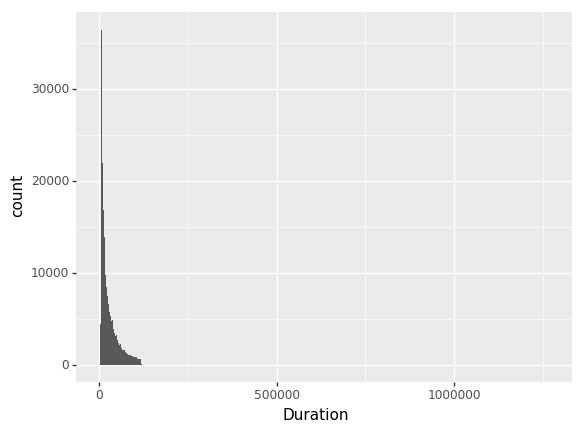

<ggplot: (-9223363243399717155)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 174'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 25082 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


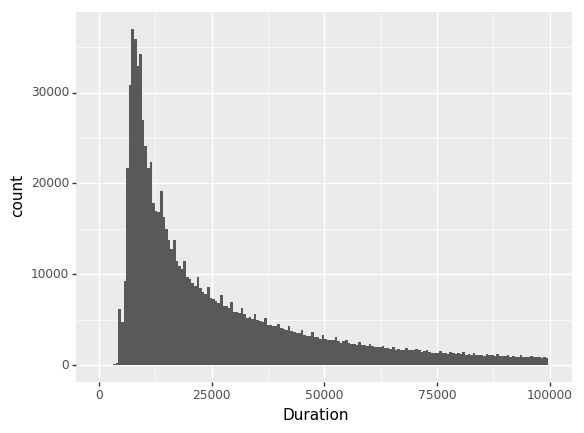

<ggplot: (-9223363243399503160)>

In [169]:
ggplot(durations_df_bbn, aes(x="Duration")) + geom_histogram()
# ggplot(durations_df_bbn, aes(x="Duration")) + geom_histogram() + xlim(0.0,100000)
bbn_durations_plot = ggplot(durations_df_bbn, aes(x="Duration")) + geom_histogram() + xlim(0.0,100000)
bbn_durations_plot

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 370'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


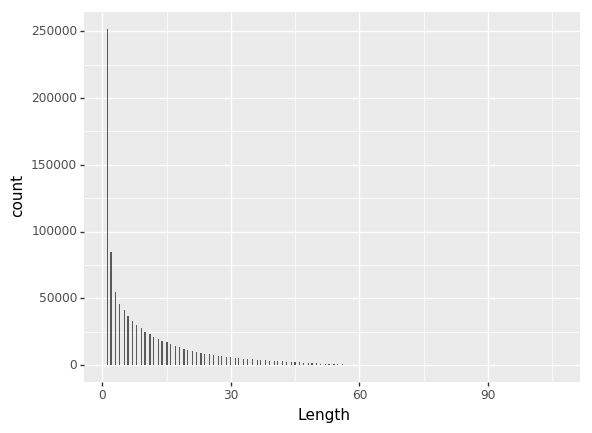

<ggplot: (8793513629602)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 208'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 1266 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


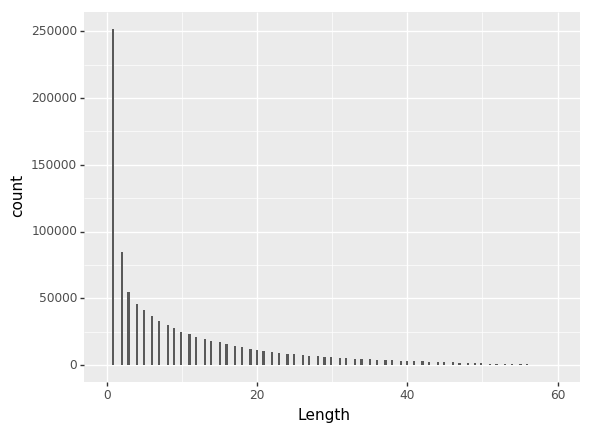

<ggplot: (-9223363243568208454)>

In [170]:
ggplot(lengths_df_bbn, aes(x="Length")) + geom_histogram()
# ggplot(lengths_df_bbn, aes(x="Length")) + geom_histogram() + xlim(0.0, 60.0)
bbn_lengths_plot = ggplot(lengths_df_bbn, aes(x="Length")) + geom_histogram() + xlim(0.0, 60.0)
bbn_lengths_plot

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 2843'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


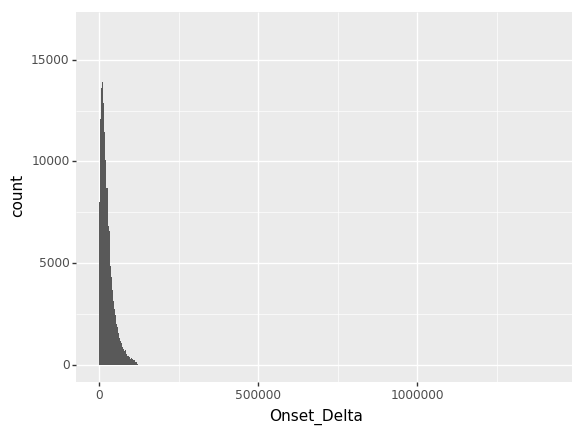

<ggplot: (8793286707667)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 201'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 9531 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


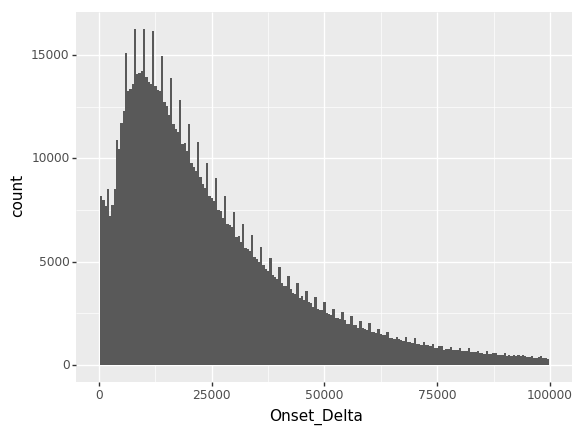

<ggplot: (-9223363243568072546)>

In [171]:
ggplot(onset_deltas_df_bbn, aes(x="Onset_Delta")) + geom_histogram()
# ggplot(onset_deltas_df_bbn, aes(x="Onset_Delta")) + geom_histogram() + xlim(0.0, 100000)
bbn_onset_deltas_plot = ggplot(onset_deltas_df_bbn, aes(x="Onset_Delta")) + geom_histogram() + xlim(0.0, 100000)
bbn_onset_deltas_plot

### Side-by-side plot comparisons

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 318'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 28 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


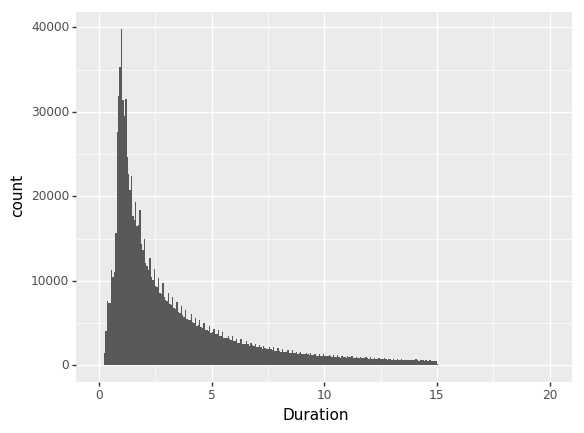

<ggplot: (8793386866366)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 174'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 25082 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


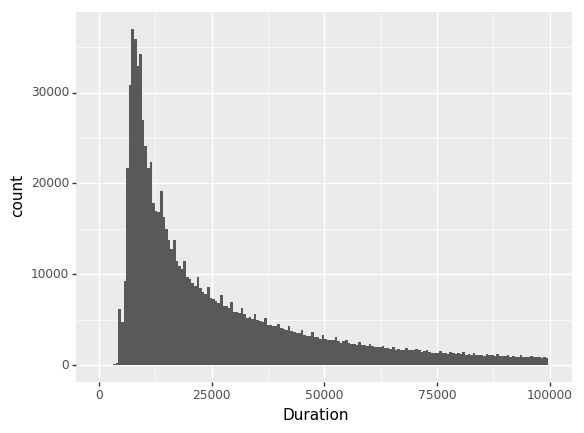

<ggplot: (-9223363243399503160)>

In [172]:
main_durations_plot
bbn_durations_plot

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 236'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 1271 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


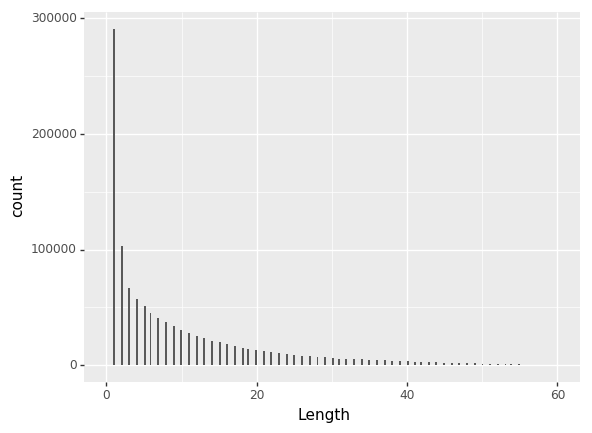

<ggplot: (8793383144617)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 208'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 1266 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


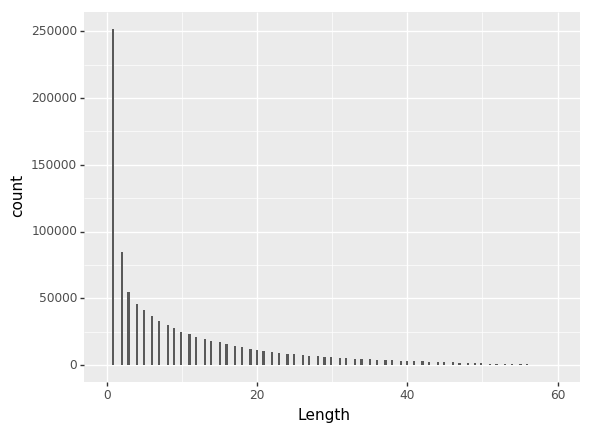

<ggplot: (-9223363243568208454)>

In [173]:
main_length_plot
bbn_lengths_plot

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 355'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 204 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


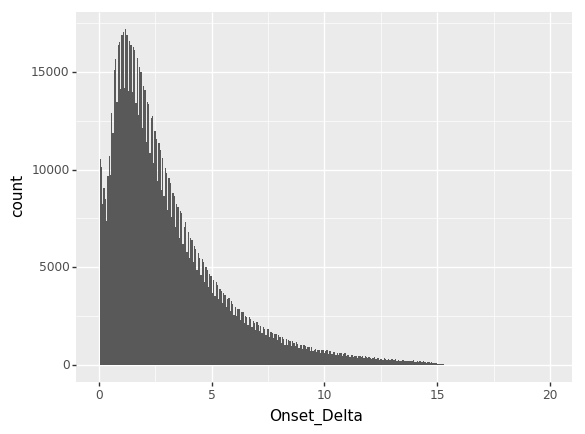

<ggplot: (8793455387968)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 201'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 9531 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


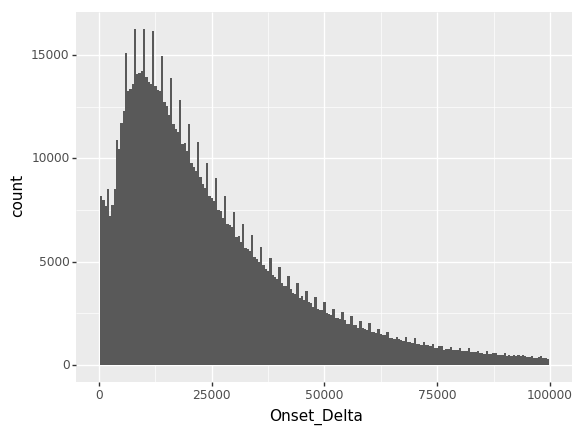

<ggplot: (-9223363243568072546)>

In [174]:
main_onset_deltas_plot
bbn_onset_deltas_plot

## Useful examples

In [175]:
bbn_transcription_relation[3]

{'speaker': 'A',
 'n_words': 4,
 'duration': 11040,
 'call_id': '05863',
 'utterance_id': 'fe_03_05863-A-0004',
 'speech_raw': "I'M FINE AND YOU",
 'end': 88320,
 'start': 77280,
 'audio_fn': 'fe_03_05863.sph',
 'channel': 1,
 'has_words': True,
 'type': 'NIST_1A',
 'speech': "i'm fine and you",
 'rejected_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.trn',
 'rejected_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/rejected/fe_03_05863.ana',
 'ana_fn': 'fe_03_05863.ana',
 'auto-segmented_trn_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.trn',
 'trn_fn': 'fe_03_05863.trn',
 'auto-segmented_ana_location': '/mnt/truffle/corpora/fisher_english_transcripts/fe_03_p2_tran/data/bbn_orig/058/auto-segmented/fe_03_05863.ana'}

In [176]:
# tsFor10622 = [t for t in bbn_transcription_relation if t['call_id'] == '10622']
# len(tsFor10622)

In [177]:
# [t for t in bbn_transcription_relation if 'BIO TERROR' in t['speech']]

# Using `kenlm`

In [178]:
os.chdir(repo_dir)
os.getcwd()

'/mnt/cube/home/AD/emeinhar/fisher-lm'

In [179]:
%ls

 fisher_utterances_bbn.txt
 fisher_utterances_main.txt
 fisher_utterances_relation_bbn.json
 fisher_utterances_relation_main.json
 fisher_vocabulary_bbn.txt
 fisher_vocabulary_main.txt
'Preprocessing Fisher corpus transcriptions for ease of processing and use with kenlm.ipynb'


## Check for format complaints

Below is a dummy run, where we create a unigram model from 
 - fisher_utterances_main.txt
 - fisher_utterances_bbn.txt
to see if kenlm complains about the format of the files.

In [180]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 1 --text fisher_utterances_main.txt --arpa fisher_utterances_main_1gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_main.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 10731876 types 44067
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:528804
Statistics:
1 44067 D1=0.566009 D2=0.988153 D3+=1.45856
Memory estimate for binary LM:
type      kB
probing 1893 assuming -p 1.5
probing 2065 assuming -r models -p 1.5
trie    1285 without quantization
trie    1160 assuming -q 8 -b 8 quantization 
trie    1285 assuming -a 22 array pointer compression
trie    1160 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:528804
=== 4/5 Calculating and writing order-interpolated probabilities ===
Chain sizes: 1:528804
=== 5/5 Writing ARPA 

In [181]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 1 --text fisher_utterances_bbn.txt --arpa fisher_utterances_bbn_1gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_bbn.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 9641143 types 42016
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:504192
Statistics:
1 42016 D1=0.560428 D2=1.0005 D3+=1.43457
Memory estimate for binary LM:
type      kB
probing 1805 assuming -p 1.5
probing 1969 assuming -r models -p 1.5
trie    1225 without quantization
trie    1106 assuming -q 8 -b 8 quantization 
trie    1225 assuming -a 22 array pointer compression
trie    1106 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:504192
=== 4/5 Calculating and writing order-interpolated probabilities ===
Chain sizes: 1:504192
=== 5/5 Writing ARPA mode

## Timing tests

Estimating a unigram model takes about 9s. Let's see how long progressively larger models take to estimate.

In [182]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 2 --text fisher_utterances_main.txt --arpa fisher_utterances_main_2gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_main.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 10731876 types 44067
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:528804 2:108102156288
Statistics:
1 44067 D1=0.573987 D2=0.970821 D3+=1.48062
2 918933 D1=0.686281 D2=1.07337 D3+=1.39033
Memory estimate for binary LM:
type       kB
probing 17272 assuming -p 1.5
probing 17444 assuming -r models -p 1.5
trie     6305 without quantization
trie     3726 assuming -q 8 -b 8 quantization 
trie     6305 assuming -a 22 array pointer compression
trie     3726 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:528804 2:14702928
----5---10---15---20---25---30---35

In [183]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 2 --text fisher_utterances_bbn.txt --arpa fisher_utterances_bbn_2gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_bbn.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 9641143 types 42016
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:504192 2:108102180864
Statistics:
1 42016 D1=0.568433 D2=0.981916 D3+=1.4966
2 861818 D1=0.687395 D2=1.07196 D3+=1.3933
Memory estimate for binary LM:
type       kB
probing 16215 assuming -p 1.5
probing 16380 assuming -r models -p 1.5
trie     5929 without quantization
trie     3510 assuming -q 8 -b 8 quantization 
trie     5929 assuming -a 22 array pointer compression
trie     3510 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:504192 2:13789088
----5---10---15---20---25---30---35---4

In [184]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 3 --text fisher_utterances_main.txt --arpa fisher_utterances_main_3gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_main.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 10731876 types 44067
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:528804 2:37600751616 3:70501408768
Statistics:
1 44067 D1=0.573987 D2=0.970821 D3+=1.48062
2 918933 D1=0.699343 D2=1.08262 D3+=1.4012
3 3530719 D1=0.781713 D2=1.0944 D3+=1.33275
Memory estimate for binary LM:
type    MB
probing 82 assuming -p 1.5
probing 88 assuming -r models -p 1.5
trie    31 without quantization
trie    17 assuming -q 8 -b 8 quantization 
trie    30 assuming -a 22 array pointer compression
trie    15 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:528804 2:14702928 

In [185]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 3 --text fisher_utterances_bbn.txt --arpa fisher_utterances_bbn_3gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_bbn.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 9641143 types 42016
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:504192 2:37600759808 3:70501425152
Statistics:
1 42016 D1=0.568433 D2=0.981916 D3+=1.4966
2 861818 D1=0.700473 D2=1.08569 D3+=1.39281
3 3266234 D1=0.783325 D2=1.09392 D3+=1.33518
Memory estimate for binary LM:
type    MB
probing 76 assuming -p 1.5
probing 81 assuming -r models -p 1.5
trie    29 without quantization
trie    15 assuming -q 8 -b 8 quantization 
trie    28 assuming -a 22 array pointer compression
trie    14 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:504192 2:13789088 3

In [186]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 4 --text fisher_utterances_main.txt --arpa fisher_utterances_main_4gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_main.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 10731876 types 44067
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:528804 2:18400366592 3:34500685824 4:55201099776
Statistics:
1 44067 D1=0.573987 D2=0.970821 D3+=1.48062
2 918933 D1=0.699343 D2=1.08262 D3+=1.4012
3 3530719 D1=0.795603 D2=1.11509 D3+=1.37541
4 6315659 D1=0.865325 D2=1.16156 D3+=1.32481
Memory estimate for binary LM:
type     MB
probing 211 assuming -p 1.5
probing 236 assuming -r models -p 1.5
trie     90 without quantization
trie     48 assuming -q 8 -b 8 quantization 
trie     82 assuming -a 22 array pointer compression
trie     40 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and 

In [187]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 4 --text fisher_utterances_bbn.txt --arpa fisher_utterances_bbn_4gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_bbn.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 9641143 types 42016
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:504192 2:18400370688 3:34500694016 4:55201112064
Statistics:
1 42016 D1=0.568433 D2=0.981916 D3+=1.4966
2 861818 D1=0.700473 D2=1.08569 D3+=1.39281
3 3266234 D1=0.797302 D2=1.11612 D3+=1.37803
4 5794592 D1=0.867362 D2=1.16376 D3+=1.32942
Memory estimate for binary LM:
type     MB
probing 194 assuming -p 1.5
probing 218 assuming -r models -p 1.5
trie     83 without quantization
trie     44 assuming -q 8 -b 8 quantization 
trie     76 assuming -a 22 array pointer compression
trie     37 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and so

In [188]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 5 --text fisher_utterances_main.txt --arpa fisher_utterances_main_5gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_main.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 10731876 types 44067
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:528804 2:10546551808 3:19774785536 4:31639654400 5:46141165568
Statistics:
1 44067 D1=0.573987 D2=0.970821 D3+=1.48062
2 918933 D1=0.699343 D2=1.08262 D3+=1.4012
3 3530719 D1=0.795603 D2=1.11509 D3+=1.37541
4 6315659 D1=0.878533 D2=1.1968 D3+=1.37818
5 7650530 D1=0.930477 D2=1.2561 D3+=1.35534
Memory estimate for binary LM:
type     MB
probing 378 assuming -p 1.5
probing 440 assuming -r models -p 1.5
trie    174 without quantization
trie     93 assuming -q 8 -b 8 quantization 
trie    154 assuming -a 22 array pointer compression
trie     73 assuming -a 22 -q 8 -b 8 array poin

In [189]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/lmplz -o 5 --text fisher_utterances_bbn.txt --arpa fisher_utterances_bbn_5gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_bbn.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 9641143 types 42016
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:504192 2:10546553856 3:19774789632 4:31639660544 5:46141177856
Statistics:
1 42016 D1=0.568433 D2=0.981916 D3+=1.4966
2 861818 D1=0.700473 D2=1.08569 D3+=1.39281
3 3266234 D1=0.797302 D2=1.11612 D3+=1.37803
4 5794592 D1=0.880501 D2=1.20152 D3+=1.37819
5 6996024 D1=0.932361 D2=1.25759 D3+=1.37719
Memory estimate for binary LM:
type     MB
probing 348 assuming -p 1.5
probing 405 assuming -r models -p 1.5
trie    160 without quantization
trie     85 assuming -q 8 -b 8 quantization 
trie    142 assuming -a 22 array pointer compression
trie     67 assuming -a 22 -q 8 -b 8 array poin

## Query an n-gram model

In [190]:
%ls *gram.arpa

fisher_utterances_bbn_1gram.arpa  fisher_utterances_main_1gram.arpa
fisher_utterances_bbn_2gram.arpa  fisher_utterances_main_2gram.arpa
fisher_utterances_bbn_3gram.arpa  fisher_utterances_main_3gram.arpa
fisher_utterances_bbn_4gram.arpa  fisher_utterances_main_4gram.arpa
fisher_utterances_bbn_5gram.arpa  fisher_utterances_main_5gram.arpa


In [191]:
!echo "how's it going" | /home/AD/emeinhar/GitHub/kenlm/build/bin/query fisher_utterances_main_5gram.arpa

Loading the LM will be faster if you build a binary file.
Reading fisher_utterances_main_5gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
how's=3183 2 -3.7624419	it=82 3 -0.3159168	going=156 4 -0.05819364	</s>=2 5 -0.12938201	Total: -4.2659345 OOV: 0
Perplexity including OOVs:	11.65423086000582
Perplexity excluding OOVs:	11.65423086000582
OOVs:	0
Tokens:	4
Name:query	VmPeak:418440 kB	VmRSS:4940 kB	RSSMax:393296 kB	user:7.23749	sys:0.09991	CPU:7.33743	real:7.34128


In [192]:
!/home/AD/emeinhar/GitHub/kenlm/build/bin/build_binary fisher_utterances_main_5gram.arpa fisher_utterances_main_5gram.mmap

Reading fisher_utterances_main_5gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
SUCCESS


In [193]:
!echo "how's it going" | /home/AD/emeinhar/GitHub/kenlm/build/bin/query fisher_utterances_main_5gram.mmap

This binary file contains probing hash tables.
how's=3183 2 -3.7624419	it=82 3 -0.3159168	going=156 4 -0.05819364	</s>=2 5 -0.12938201	Total: -4.2659345 OOV: 0
Perplexity including OOVs:	11.65423086000582
Perplexity excluding OOVs:	11.65423086000582
OOVs:	0
Tokens:	4
Name:query	VmPeak:416400 kB	VmRSS:4940 kB	RSSMax:392856 kB	user:0	sys:0.023481	CPU:0.023512	real:0.0227069


Assuming `real:0.0245038` at the bottom indicates the real (≈wall clock time from start to finish) duration in s, that's 24.5ms.

## python module

In [194]:
import kenlm

In [195]:
os.getcwd()

'/mnt/cube/home/AD/emeinhar/fisher-lm'

In [196]:
arpa_files = [fn for fn in os.listdir()
              if '.arpa' in fn
              and 'main' in fn]; arpa_files

['fisher_utterances_main_5gram.arpa',
 'fisher_utterances_main_2gram.arpa',
 'fisher_utterances_main_4gram.arpa',
 'fisher_utterances_main_3gram.arpa',
 'fisher_utterances_main_1gram.arpa']

In [197]:
# from random import choice
# my_arpa_filename = choice(arpa_files); my_arpa_filename

my_arpa_filename = 'fisher_utterances_main_5gram.arpa'

In [198]:
LM_fp = os.path.join(os.getcwd(), my_arpa_filename); LM_fp

'/mnt/cube/home/AD/emeinhar/fisher-lm/fisher_utterances_main_5gram.arpa'

In [199]:
model = kenlm.LanguageModel(LM_fp)
print('{0}-gram model'.format(model.order))

5-gram model


In [200]:
sentence = "how's it going"

In [201]:
model.score(sentence)

-4.265934467315674